In [4]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import hjb_modified, hjb_modified_vanishing_viscosity
from numba import njit

Equation with damage function $j$:

\begin{align}
0 = \max_e \min_{h_2} &-\delta \phi(y,z_2) + \delta\eta\log e  + \frac{\partial \phi}{\partial y}(y, z_2) z_2 e + \frac{\partial^2 \phi}{\partial y^2}(y, z_2) \epsilon\\
&+ \left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\left[-\rho(z_2 -  \mu_{2}) \right] + \left[\frac{\partial^2 \phi}{\partial (z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)\\
& + (\eta-1)\left(\frac{d}{d \tau}\Lambda_j(y)z_2 e\right)\\
\end{align}

where

\begin{equation}
\Lambda_j(\tau)=
\begin{cases}
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2, & \tau\leq \bar{\tau} \\
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2 + \frac{\lambda_{2,j}^+}{2}(\tau-\bar{\tau})^2, & \tau > \bar{\tau}
\end{cases}
\end{equation}

FOC of $e$ gives :

$$
e^* = -\frac{\delta \eta}{\frac{\partial \phi}{\partial y}(y, z_2)z_2 + (\eta-1)\frac{d}{d \tau}\Lambda_j(y)z_2}
$$

In [2]:
# Model parameters
η = .032
δ = .01
# Z process
μ_2 = 1.86/1000.
ρ = 0.9
σ_2 = np.sqrt(2*ρ/10416.29)
# Damage setting
λ_1 = 1.7675/10000
λ_2 = 0.0022*2
λ_bar = 2.
# Three damages
# λ_2p_state = np.array([0., 0.0197*2, 0.3853*2])
# λ_2p_prior = np.array([0.4875, 0.4875, 0.025])
# Two damages
λ_2p_state = np.array([0., 0.0197*2])

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

In [3]:
# Grid setting
n_z = 50
z_min = np.max([μ_2 - 3*np.sqrt(σ_2**2*μ_2/(2*ρ)), 1e-9])
z_max = μ_2 + 3*np.sqrt(σ_2**2*μ_2/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

n_y = 50
y_min = 1e-10
y_max = 10
y_grid = np.linspace(y_min, y_max, n_y)

# Solve for each damage function
ϕ_state = []
for λ_2p in λ_2p_state:
    pde_paras = (η, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p)
    ϕ, _ = hjb_modified(z_grid, y_grid, model_paras=pde_paras, v0=None,
                           ϵ=.5, tol=1e-8, max_iter=10_000, use_python=False)
    ϕ_state.append(ϕ)

# Compute boundary condition
ϕ_mean = np.average(np.array(ϕ_state), axis=0, weights=[0.5, 0.5])
ϕ_bc = np.zeros_like(z_grid)
for i in range(len(z_grid)):
    ϕ_bc[i] = np.interp(λ_bar, y_grid, ϕ_mean[i])
bc_5 = (np.zeros(1), np.zeros(1), np.zeros(1), ϕ_bc)
impose_bc_5 = (False, False, False, True)

ϕ_mean = np.average(np.array(ϕ_state), axis=0, weights=[0.4, 0.6])
ϕ_bc = np.zeros_like(z_grid)
for i in range(len(z_grid)):
    ϕ_bc[i] = np.interp(λ_bar, y_grid, ϕ_mean[i])
bc_6 = (np.zeros(1), np.zeros(1), np.zeros(1), ϕ_bc)
impose_bc_6 = (False, False, False, True)

ϕ_mean = np.average(np.array(ϕ_state), axis=0, weights=[0.3, 0.7])
ϕ_bc = np.zeros_like(z_grid)
for i in range(len(z_grid)):
    ϕ_bc[i] = np.interp(λ_bar, y_grid, ϕ_mean[i])
bc_7 = (np.zeros(1), np.zeros(1), np.zeros(1), ϕ_bc)
impose_bc_7 = (False, False, False, True)

Iteration 1: LHS Error: 0.0014451636931549635; RHS Error 0.0018258099200731185
Iteration 2: LHS Error: 0.0013259298265649209; RHS Error 0.0015870481258874083
Iteration 3: LHS Error: 0.0012489890928941943; RHS Error 0.0014341936562414616
Iteration 4: LHS Error: 0.0011924643904215274; RHS Error 0.0013256548324169116
Iteration 5: LHS Error: 0.0011464755682885977; RHS Error 0.0012433684624314108
Iteration 6: LHS Error: 0.0011067084717271735; RHS Error 0.0011782676056142274
Iteration 7: LHS Error: 0.0010714123281512257; RHS Error 0.001125323000374886
Iteration 8: LHS Error: 0.0010398559227960246; RHS Error 0.0010814396887144214
Iteration 9: LHS Error: 0.001011608054127408; RHS Error 0.0010445063040953764
Iteration 10: LHS Error: 0.0009862799201139985; RHS Error 0.0010129711800735076
Iteration 11: LHS Error: 0.0009634783799504117; RHS Error 0.0009856532271039168
Iteration 12: LHS Error: 0.0009428251125487702; RHS Error 0.0009616462935188826
Iteration 13: LHS Error: 0.000923979829729981; RHS 

Iteration 109: LHS Error: 0.0003682498004889956; RHS Error 0.00036914860959952507
Iteration 110: LHS Error: 0.00036553944769754376; RHS Error 0.0003664259919470873
Iteration 111: LHS Error: 0.0003628544397792782; RHS Error 0.0003637289582328897
Iteration 112: LHS Error: 0.0003601944226060555; RHS Error 0.0003610571476126799
Iteration 113: LHS Error: 0.00035755904959919316; RHS Error 0.00035841020945857606
Iteration 114: LHS Error: 0.0003549479823503898; RHS Error 0.00035578779607930554
Iteration 115: LHS Error: 0.0003523608894635405; RHS Error 0.0003531895717556726
Iteration 116: LHS Error: 0.0003497974470190873; RHS Error 0.0003506152051319572
Iteration 117: LHS Error: 0.00034725733788767976; RHS Error 0.00034806437781851154
Iteration 118: LHS Error: 0.0003447402516433551; RHS Error 0.0003455367708066531
Iteration 119: LHS Error: 0.0003422458842451681; RHS Error 0.0003430320741601002
Iteration 120: LHS Error: 0.0003397739380567588; RHS Error 0.0003405499875141164
Iteration 121: LHS Er

Iteration 213: LHS Error: 0.00017994109795706204; RHS Error 0.00018022420294736214
Iteration 214: LHS Error: 0.00017876725352779232; RHS Error 0.0001790477051751469
Iteration 215: LHS Error: 0.00017760185400894635; RHS Error 0.00017787967759375078
Iteration 216: LHS Error: 0.00017644482754171353; RHS Error 0.00017672005507169417
Iteration 217: LHS Error: 0.00017529610311842192; RHS Error 0.0001755687645065314
Iteration 218: LHS Error: 0.00017415561062578133; RHS Error 0.00017442573687253605
Iteration 219: LHS Error: 0.00017302328267176925; RHS Error 0.00017329090095262077
Iteration 220: LHS Error: 0.00017189904462695804; RHS Error 0.00017216418005528084
Iteration 221: LHS Error: 0.0001707828328218891; RHS Error 0.00017104552033987773
Iteration 222: LHS Error: 0.00016967457858296786; RHS Error 0.00016993483967805512
Iteration 223: LHS Error: 0.00016857421617254287; RHS Error 0.00016883208119758994
Iteration 224: LHS Error: 0.00016748167965618954; RHS Error 0.00016773717579729073
Iterati

Iteration 317: LHS Error: 9.28184897183576e-05; RHS Error 9.293386342331842e-05
Iteration 318: LHS Error: 9.224292314402582e-05; RHS Error 9.235737589991053e-05
Iteration 319: LHS Error: 9.167112690873502e-05; RHS Error 9.178466614432159e-05
Iteration 320: LHS Error: 9.110307454171518e-05; RHS Error 9.12157097449726e-05
Iteration 321: LHS Error: 9.053873883052566e-05; RHS Error 9.065047861780398e-05
Iteration 322: LHS Error: 8.99780942344025e-05; RHS Error 9.008894522681565e-05
Iteration 323: LHS Error: 8.942111419764365e-05; RHS Error 8.953108607055184e-05
Iteration 324: LHS Error: 8.886777177281868e-05; RHS Error 8.897686970266887e-05
Iteration 325: LHS Error: 8.831804129764975e-05; RHS Error 8.842627353103307e-05
Iteration 326: LHS Error: 8.777189800819596e-05; RHS Error 8.787927225340517e-05
Iteration 327: LHS Error: 8.722931569678238e-05; RHS Error 8.733584180286213e-05
Iteration 328: LHS Error: 8.669026920726797e-05; RHS Error 8.67959558929056e-05
Iteration 329: LHS Error: 8.6154

Iteration 426: LHS Error: 4.7633107503927685e-05; RHS Error 4.768335246207176e-05
Iteration 427: LHS Error: 4.734653063488692e-05; RHS Error 4.739640962361162e-05
Iteration 428: LHS Error: 4.70617400914336e-05; RHS Error 4.711125511825331e-05
Iteration 429: LHS Error: 4.67787239302464e-05; RHS Error 4.682788142129494e-05
Iteration 430: LHS Error: 4.649747063671661e-05; RHS Error 4.654626851850405e-05
Iteration 431: LHS Error: 4.621796863538141e-05; RHS Error 4.626641226211756e-05
Iteration 432: LHS Error: 4.5940206435057807e-05; RHS Error 4.598830035811583e-05
Iteration 433: LHS Error: 4.56641725438689e-05; RHS Error 4.57119182304456e-05
Iteration 434: LHS Error: 4.538985573512844e-05; RHS Error 4.543725349556412e-05
Iteration 435: LHS Error: 4.511724479808188e-05; RHS Error 4.516429971763774e-05
Iteration 436: LHS Error: 4.484632848035519e-05; RHS Error 4.489304518744575e-05
Iteration 437: LHS Error: 4.457709572151802e-05; RHS Error 4.462347502214991e-05
Iteration 438: LHS Error: 4.43

Iteration 533: LHS Error: 2.513881584025046e-05; RHS Error 2.516247855658977e-05
Iteration 534: LHS Error: 2.4990490904458484e-05; RHS Error 2.5013982492845272e-05
Iteration 535: LHS Error: 2.484305499203532e-05; RHS Error 2.4866381951986764e-05
Iteration 536: LHS Error: 2.4696511877933536e-05; RHS Error 2.4719689012135736e-05
Iteration 537: LHS Error: 2.455085600491791e-05; RHS Error 2.457388096660984e-05
Iteration 538: LHS Error: 2.4406082390057704e-05; RHS Error 2.442895202080708e-05
Iteration 539: LHS Error: 2.4262182118123254e-05; RHS Error 2.4284896725986827e-05
Iteration 540: LHS Error: 2.4119153338664212e-05; RHS Error 2.4141710185344653e-05
Iteration 541: LHS Error: 2.3976987211446477e-05; RHS Error 2.3999392757222604e-05
Iteration 542: LHS Error: 2.3835679286016154e-05; RHS Error 2.385793117371665e-05
Iteration 543: LHS Error: 2.3695226145745152e-05; RHS Error 2.3717326087985637e-05
Iteration 544: LHS Error: 2.3555620971574265e-05; RHS Error 2.3577568048312593e-05
Iteration 5

Iteration 635: LHS Error: 1.3803894128541772e-05; RHS Error 1.3815813132690442e-05
Iteration 636: LHS Error: 1.3723522173728075e-05; RHS Error 1.3735362896077409e-05
Iteration 637: LHS Error: 1.3643627182272078e-05; RHS Error 1.3655390030881836e-05
Iteration 638: LHS Error: 1.3564206251398536e-05; RHS Error 1.357589150129796e-05
Iteration 639: LHS Error: 1.3485256491654884e-05; RHS Error 1.3496865426673244e-05
Iteration 640: LHS Error: 1.3406775014213057e-05; RHS Error 1.341830766686937e-05
Iteration 641: LHS Error: 1.3328758980510336e-05; RHS Error 1.3340215124705299e-05
Iteration 642: LHS Error: 1.3251205569428381e-05; RHS Error 1.3262586361639794e-05
Iteration 643: LHS Error: 1.3174111957670043e-05; RHS Error 1.3185417816747539e-05
Iteration 644: LHS Error: 1.3097475333900821e-05; RHS Error 1.3108707532649721e-05
Iteration 645: LHS Error: 1.3021292920606387e-05; RHS Error 1.3032450746628017e-05
Iteration 646: LHS Error: 1.2945561963212393e-05; RHS Error 1.2956647241748427e-05
Iterat

Iteration 737: LHS Error: 7.632661485970638e-06; RHS Error 7.638800575737888e-06
Iteration 738: LHS Error: 7.58866737003705e-06; RHS Error 7.594764674748308e-06
Iteration 739: LHS Error: 7.5449309262232145e-06; RHS Error 7.55099127379465e-06
Iteration 740: LHS Error: 7.501450172725521e-06; RHS Error 7.507471403751993e-06
Iteration 741: LHS Error: 7.458223706235945e-06; RHS Error 7.464207238369255e-06
Iteration 742: LHS Error: 7.415250004152996e-06; RHS Error 7.4211954991867946e-06
Iteration 743: LHS Error: 7.372527585314259e-06; RHS Error 7.378434351605514e-06
Iteration 744: LHS Error: 7.330054956053433e-06; RHS Error 7.335923935214168e-06
Iteration 745: LHS Error: 7.287830627741854e-06; RHS Error 7.293661790596512e-06
Iteration 746: LHS Error: 7.245853111820244e-06; RHS Error 7.25164750140124e-06
Iteration 747: LHS Error: 7.204120934425906e-06; RHS Error 7.209878923883535e-06
Iteration 748: LHS Error: 7.16263261235639e-06; RHS Error 7.168354613920581e-06
Iteration 749: LHS Error: 7.12

Iteration 839: LHS Error: 4.242725980652118e-06; RHS Error 6.134598086849881e-06
Iteration 840: LHS Error: 4.218462800215095e-06; RHS Error 6.158529930255525e-06
Iteration 841: LHS Error: 4.194340057869783e-06; RHS Error 6.1823252732679315e-06
Iteration 842: LHS Error: 4.170356881549875e-06; RHS Error 6.205982218684004e-06
Iteration 843: LHS Error: 4.14651241419095e-06; RHS Error 6.229503856041048e-06
Iteration 844: LHS Error: 4.122805929360207e-06; RHS Error 6.252887809489764e-06
Iteration 845: LHS Error: 4.09923655754485e-06; RHS Error 6.276137461446243e-06
Iteration 846: LHS Error: 4.0758034909604834e-06; RHS Error 6.299252504177481e-06
Iteration 847: LHS Error: 4.0525059832874355e-06; RHS Error 6.322234553200658e-06
Iteration 848: LHS Error: 4.0293431744498065e-06; RHS Error 6.345082937567886e-06
Iteration 849: LHS Error: 4.0063142708601784e-06; RHS Error 6.367800326807392e-06
Iteration 850: LHS Error: 3.983418531944283e-06; RHS Error 6.390386164697873e-06
Iteration 851: LHS Error:

Iteration 948: LHS Error: 2.275513216493108e-06; RHS Error 8.075613835968783e-06
Iteration 949: LHS Error: 2.2625836064299465e-06; RHS Error 8.088375696941501e-06
Iteration 950: LHS Error: 2.2497283003741764e-06; RHS Error 8.10106433278752e-06
Iteration 951: LHS Error: 2.2369468514332747e-06; RHS Error 8.113680167483664e-06
Iteration 952: LHS Error: 2.2242388306309424e-06; RHS Error 8.126223673935503e-06
Iteration 953: LHS Error: 2.2116037997343962e-06; RHS Error 8.138695246977593e-06
Iteration 954: LHS Error: 2.199041325853801e-06; RHS Error 8.15109531541341e-06
Iteration 955: LHS Error: 2.1865509548524287e-06; RHS Error 8.163424288457066e-06
Iteration 956: LHS Error: 2.1741323330548568e-06; RHS Error 8.175682314580943e-06
Iteration 957: LHS Error: 2.1617849463306804e-06; RHS Error 8.18787062451822e-06
Iteration 958: LHS Error: 2.1495084348566174e-06; RHS Error 8.199988608466975e-06
Iteration 959: LHS Error: 2.1373023695175908e-06; RHS Error 8.212037370433417e-06
Iteration 960: LHS Er

Iteration 1058: LHS Error: 1.2179763921177367e-06; RHS Error 9.119767495867782e-06
Iteration 1059: LHS Error: 1.211137010154184e-06; RHS Error 9.126561029115235e-06
Iteration 1060: LHS Error: 1.204272150293062e-06; RHS Error 9.133321332643147e-06
Iteration 1061: LHS Error: 1.1974538040027127e-06; RHS Error 9.140040835228357e-06
Iteration 1062: LHS Error: 1.1906805172379187e-06; RHS Error 9.146720770884624e-06
Iteration 1063: LHS Error: 1.183950203209605e-06; RHS Error 9.153362925121405e-06
Iteration 1064: LHS Error: 1.1772624552292e-06; RHS Error 9.159967887064887e-06
Iteration 1065: LHS Error: 1.1706131349403792e-06; RHS Error 9.166535765899216e-06
Iteration 1066: LHS Error: 1.1640015192132536e-06; RHS Error 9.173066629946693e-06
Iteration 1067: LHS Error: 1.1574273896391984e-06; RHS Error 9.17956056648646e-06
Iteration 1068: LHS Error: 1.1508905328749819e-06; RHS Error 9.18601774407184e-06
Iteration 1069: LHS Error: 1.1443907343838822e-06; RHS Error 9.192438370257293e-06
Iteration 10

Iteration 1165: LHS Error: 6.649903349087438e-07; RHS Error 9.666028025694367e-06
Iteration 1166: LHS Error: 6.612471143002674e-07; RHS Error 9.669726754535368e-06
Iteration 1167: LHS Error: 6.575251040863428e-07; RHS Error 9.673404417227544e-06
Iteration 1168: LHS Error: 6.538241915376997e-07; RHS Error 9.677061126334499e-06
Iteration 1169: LHS Error: 6.501442152001546e-07; RHS Error 9.680697213368611e-06
Iteration 1170: LHS Error: 6.464850714898995e-07; RHS Error 9.684312708122022e-06
Iteration 1171: LHS Error: 6.428466367419672e-07; RHS Error 9.687907756592094e-06
Iteration 1172: LHS Error: 6.392287954098963e-07; RHS Error 9.69148248637793e-06
Iteration 1173: LHS Error: 6.356314299904575e-07; RHS Error 9.69503698319634e-06
Iteration 1174: LHS Error: 6.320544245069781e-07; RHS Error 9.698571381550839e-06
Iteration 1175: LHS Error: 6.284976625664518e-07; RHS Error 9.702085793858884e-06
Iteration 1176: LHS Error: 6.250479454295021e-07; RHS Error 9.705580398825615e-06
Iteration 1177: LH

Iteration 1273: LHS Error: 3.6180640217153837e-07; RHS Error 9.965627012984302e-06
Iteration 1274: LHS Error: 3.5977713269685907e-07; RHS Error 9.967632902190991e-06
Iteration 1275: LHS Error: 3.57759247796019e-07; RHS Error 9.969627621950585e-06
Iteration 1276: LHS Error: 3.5575266614518153e-07; RHS Error 9.97161125322393e-06
Iteration 1277: LHS Error: 3.5375731304021496e-07; RHS Error 9.973583864172865e-06
Iteration 1278: LHS Error: 3.5177311613621143e-07; RHS Error 9.975545472041408e-06
Iteration 1279: LHS Error: 3.4980000403195266e-07; RHS Error 9.977496237574893e-06
Iteration 1280: LHS Error: 3.478379146520938e-07; RHS Error 9.979436100784628e-06
Iteration 1281: LHS Error: 3.458867821187761e-07; RHS Error 9.981365161027987e-06
Iteration 1282: LHS Error: 3.439465443844103e-07; RHS Error 9.98328346499917e-06
Iteration 1283: LHS Error: 3.420171404283634e-07; RHS Error 9.985191064967999e-06
Iteration 1284: LHS Error: 3.40098511478204e-07; RHS Error 9.987088001505969e-06
Iteration 1285

Iteration 1376: LHS Error: 2.027633601991985e-07; RHS Error 1.0122845521235053e-05
Iteration 1377: LHS Error: 2.0162690611558176e-07; RHS Error 1.0123969017676983e-05
Iteration 1378: LHS Error: 2.0049684697209802e-07; RHS Error 1.0125086193494334e-05
Iteration 1379: LHS Error: 1.9937314611750967e-07; RHS Error 1.0126197068264977e-05
Iteration 1380: LHS Error: 1.982557693153142e-07; RHS Error 1.0127301683082127e-05
Iteration 1381: LHS Error: 1.97144682398398e-07; RHS Error 1.0128400071751208e-05
Iteration 1382: LHS Error: 1.9605208671780172e-07; RHS Error 1.0129492271012796e-05
Iteration 1383: LHS Error: 1.949444910914755e-07; RHS Error 1.0130583205899277e-05
Iteration 1384: LHS Error: 1.9384890470597327e-07; RHS Error 1.0131663652879208e-05
Iteration 1385: LHS Error: 1.9276264971723744e-07; RHS Error 1.013273713309842e-05
Iteration 1386: LHS Error: 1.9168256380763804e-07; RHS Error 1.0133804555070196e-05
Iteration 1387: LHS Error: 1.9060858495734134e-07; RHS Error 1.0134866071059671e-0

Iteration 1484: LHS Error: 1.1071347677527044e-07; RHS Error 1.0214000344811345e-05
Iteration 1485: LHS Error: 1.1007918389316362e-07; RHS Error 1.0214623032443922e-05
Iteration 1486: LHS Error: 1.094499727516407e-07; RHS Error 1.0215240984633991e-05
Iteration 1487: LHS Error: 1.0882545484203199e-07; RHS Error 1.0215854417003995e-05
Iteration 1488: LHS Error: 1.0820508546116603e-07; RHS Error 1.0216463496124034e-05
Iteration 1489: LHS Error: 1.0758867576010633e-07; RHS Error 1.021706836167426e-05
Iteration 1490: LHS Error: 1.069763417294034e-07; RHS Error 1.0217669124560746e-05
Iteration 1491: LHS Error: 1.0636810117425899e-07; RHS Error 1.0218267518970724e-05
Iteration 1492: LHS Error: 1.0576396917982844e-07; RHS Error 1.0218860578037206e-05
Iteration 1493: LHS Error: 1.0516371130864233e-07; RHS Error 1.021944981598839e-05
Iteration 1494: LHS Error: 1.0456739119035774e-07; RHS Error 1.0220035265723739e-05
Iteration 1495: LHS Error: 1.039750233688963e-07; RHS Error 1.02206169463534e-05

Iteration 1598: LHS Error: 5.831242867737618e-08; RHS Error 1.0265702020668998e-05
Iteration 1599: LHS Error: 5.79861065275189e-08; RHS Error 1.0266024547643743e-05
Iteration 1600: LHS Error: 5.7661606517322994e-08; RHS Error 1.026634527378405e-05
Iteration 1601: LHS Error: 5.7338918585392307e-08; RHS Error 1.0266664210430458e-05
Iteration 1602: LHS Error: 5.7018032420530496e-08; RHS Error 1.0266981365902915e-05
Iteration 1603: LHS Error: 5.6698938127874854e-08; RHS Error 1.0267296749713129e-05
Iteration 1604: LHS Error: 5.6381625104795496e-08; RHS Error 1.0267610369360091e-05
Iteration 1605: LHS Error: 5.606608452501938e-08; RHS Error 1.0267922238620759e-05
Iteration 1606: LHS Error: 5.575230566101652e-08; RHS Error 1.0268232365777136e-05
Iteration 1607: LHS Error: 5.5440279159157946e-08; RHS Error 1.0268540762875793e-05
Iteration 1608: LHS Error: 5.51299954021367e-08; RHS Error 1.026884743526575e-05
Iteration 1609: LHS Error: 5.4821444703256894e-08; RHS Error 1.0269152393734167e-05
I

Iteration 1705: LHS Error: 3.198678447113856e-08; RHS Error 1.0291809368247282e-05
Iteration 1706: LHS Error: 3.1808029876678745e-08; RHS Error 1.0291985594560772e-05
Iteration 1707: LHS Error: 3.163024915597834e-08; RHS Error 1.0292160875252426e-05
Iteration 1708: LHS Error: 3.145343571708814e-08; RHS Error 1.0292335223204517e-05
Iteration 1709: LHS Error: 3.127758542442738e-08; RHS Error 1.0292508628215354e-05
Iteration 1710: LHS Error: 3.110269332362581e-08; RHS Error 1.0292681086438186e-05
Iteration 1711: LHS Error: 3.092875539012496e-08; RHS Error 1.0292852614895856e-05
Iteration 1712: LHS Error: 3.07557623396848e-08; RHS Error 1.0293023208405661e-05
Iteration 1713: LHS Error: 3.0583716240095704e-08; RHS Error 1.0293192867775114e-05
Iteration 1714: LHS Error: 3.041260887570729e-08; RHS Error 1.0293361602123656e-05
Iteration 1715: LHS Error: 3.0242433599059204e-08; RHS Error 1.0293529418080316e-05
Iteration 1716: LHS Error: 3.007318881420584e-08; RHS Error 1.0293696311958807e-05
It

Iteration 1819: LHS Error: 1.6842353137147548e-08; RHS Error 1.0306749331741695e-05
Iteration 1820: LHS Error: 1.674732580392302e-08; RHS Error 1.0306842269135804e-05
Iteration 1821: LHS Error: 1.6652622433777076e-08; RHS Error 1.0306933997074634e-05
Iteration 1822: LHS Error: 1.655945119916069e-08; RHS Error 1.0307026702064803e-05
Iteration 1823: LHS Error: 1.6466321736685607e-08; RHS Error 1.0307118509106372e-05
Iteration 1824: LHS Error: 1.6374392300400054e-08; RHS Error 1.0307208902429841e-05
Iteration 1825: LHS Error: 1.6281730644274184e-08; RHS Error 1.0307301943553475e-05
Iteration 1826: LHS Error: 1.618890536903006e-08; RHS Error 1.030739375056859e-05
Iteration 1827: LHS Error: 1.609945299296811e-08; RHS Error 1.0307483565930768e-05
Iteration 1828: LHS Error: 1.6009125886062847e-08; RHS Error 1.0307569796039976e-05
Iteration 1829: LHS Error: 1.5918844159523715e-08; RHS Error 1.0307655852491654e-05
Iteration 1830: LHS Error: 1.5828000840545364e-08; RHS Error 1.0307743534373809e-

Iteration 7: LHS Error: 0.0010714113024877904; RHS Error 0.0011253225433237716
Iteration 8: LHS Error: 0.0010398542106298068; RHS Error 0.001081438837008392
Iteration 9: LHS Error: 0.0010116053138334805; RHS Error 0.00104450482227195
Iteration 10: LHS Error: 0.000986275679293814; RHS Error 0.001012968732244018
Iteration 11: LHS Error: 0.000963472020850422; RHS Error 0.0009856493510051753
Iteration 12: LHS Error: 0.000942815824760676; RHS Error 0.0009616403772609895
Iteration 13: LHS Error: 0.0009239666001682311; RHS Error 0.0009402486121565084
Iteration 14: LHS Error: 0.000906633128744009; RHS Error 0.0009209460686598033
Iteration 15: LHS Error: 0.0008905741669131776; RHS Error 0.0009033310166377182
Iteration 16: LHS Error: 0.0008755933186690261; RHS Error 0.0008870969111341786
Iteration 17: LHS Error: 0.0008615319123866406; RHS Error 0.0008720083582543782
Iteration 18: LHS Error: 0.0008482617786877075; RHS Error 0.0008578829213593938
Iteration 19: LHS Error: 0.0008356790262634035; RHS

Iteration 116: LHS Error: 0.00031974261696368633; RHS Error 0.0003210793337632416
Iteration 117: LHS Error: 0.000316843056418048; RHS Error 0.00031816694378465025
Iteration 118: LHS Error: 0.0003139703897265672; RHS Error 0.00031528158435925667
Iteration 119: LHS Error: 0.0003111243521667917; RHS Error 0.00031242298923418255
Iteration 120: LHS Error: 0.00030830468292039614; RHS Error 0.00030959089127930914
Iteration 121: LHS Error: 0.00030551112408233605; RHS Error 0.0003067850362230526
Iteration 122: LHS Error: 0.0003027434205624263; RHS Error 0.00030400516599488135
Iteration 123: LHS Error: 0.0003000013196147455; RHS Error 0.0003012510267389935
Iteration 124: LHS Error: 0.00029728457200935143; RHS Error 0.0002985223644320138
Iteration 125: LHS Error: 0.00029459293055555946; RHS Error 0.000295818933755729
Iteration 126: LHS Error: 0.00029192615195819394; RHS Error 0.000293140486004607
Iteration 127: LHS Error: 0.0002892839948515913; RHS Error 0.000290486784046196
Iteration 128: LHS Er

Iteration 219: LHS Error: 0.00017054489607915002; RHS Error 0.00017599383233097497
Iteration 220: LHS Error: 0.0001697018424048763; RHS Error 0.00017515080663084009
Iteration 221: LHS Error: 0.00016886295576774846; RHS Error 0.00017431194713675178
Iteration 222: LHS Error: 0.00016802821475876695; RHS Error 0.00017347723227797675
Iteration 223: LHS Error: 0.00016719759853071892; RHS Error 0.00017264664354416846
Iteration 224: LHS Error: 0.00016637109014039364; RHS Error 0.00017182016255955332
Iteration 225: LHS Error: 0.00016554866434410898; RHS Error 0.00017099776365946015
Iteration 226: LHS Error: 0.00016473030475575023; RHS Error 0.00017017943180172194
Iteration 227: LHS Error: 0.00016391599009621394; RHS Error 0.00016936514457901346
Iteration 228: LHS Error: 0.00016310570040371786; RHS Error 0.00016855488162022828
Iteration 229: LHS Error: 0.00016229941491831268; RHS Error 0.00016774862304481727
Iteration 230: LHS Error: 0.0001614971165020268; RHS Error 0.0001669463500502586
Iterati

Iteration 328: LHS Error: 9.936735983689937e-05; RHS Error 0.00010481858855620079
Iteration 329: LHS Error: 9.887612200697171e-05; RHS Error 0.00010432736811285695
Iteration 330: LHS Error: 9.838731310508886e-05; RHS Error 0.0001038385744815379
Iteration 331: LHS Error: 9.790092025029062e-05; RHS Error 0.00010335219754652332
Iteration 332: LHS Error: 9.741693184521505e-05; RHS Error 0.00010286822465633567
Iteration 333: LHS Error: 9.693533516001718e-05; RHS Error 0.00010238664478653549
Iteration 334: LHS Error: 9.645611981284885e-05; RHS Error 0.00010190744440919888
Iteration 335: LHS Error: 9.59792725101355e-05; RHS Error 0.00010143061362703637
Iteration 336: LHS Error: 9.550478280050123e-05; RHS Error 0.00010095613873555358
Iteration 337: LHS Error: 9.503263847206178e-05; RHS Error 0.0001004840098274111
Iteration 338: LHS Error: 9.45628262131043e-05; RHS Error 0.0001000142147754954
Iteration 339: LHS Error: 9.409534017590371e-05; RHS Error 9.954674463893013e-05
Iteration 340: LHS Err

Iteration 431: LHS Error: 5.964136044533941e-05; RHS Error 6.509386991053484e-05
Iteration 432: LHS Error: 5.934649628462629e-05; RHS Error 6.479901571236082e-05
Iteration 433: LHS Error: 5.905308984949231e-05; RHS Error 6.450561886728085e-05
Iteration 434: LHS Error: 5.8761133810966704e-05; RHS Error 6.42136723881518e-05
Iteration 435: LHS Error: 5.847062085127808e-05; RHS Error 6.392316908200964e-05
Iteration 436: LHS Error: 5.818154417010224e-05; RHS Error 6.363410183864556e-05
Iteration 437: LHS Error: 5.789389658815425e-05; RHS Error 6.33464636536031e-05
Iteration 438: LHS Error: 5.760767098823838e-05; RHS Error 6.306024717771171e-05
Iteration 439: LHS Error: 5.732285993324815e-05; RHS Error 6.277544569226366e-05
Iteration 440: LHS Error: 5.7039457424523654e-05; RHS Error 6.249205217165741e-05
Iteration 441: LHS Error: 5.675745524467979e-05; RHS Error 6.221005968477897e-05
Iteration 442: LHS Error: 5.647684751469706e-05; RHS Error 6.19294610088129e-05
Iteration 443: LHS Error: 5.6

Iteration 536: LHS Error: 3.544319157854081e-05; RHS Error 4.0896492780139756e-05
Iteration 537: LHS Error: 3.5267956591950034e-05; RHS Error 4.072125965094993e-05
Iteration 538: LHS Error: 3.50935857062612e-05; RHS Error 4.054689281380463e-05
Iteration 539: LHS Error: 3.492007510290385e-05; RHS Error 4.037338788799694e-05
Iteration 540: LHS Error: 3.4747422012107454e-05; RHS Error 4.020073999832472e-05
Iteration 541: LHS Error: 3.457562190668784e-05; RHS Error 4.002894562648646e-05
Iteration 542: LHS Error: 3.440467063442476e-05; RHS Error 3.9858000528655255e-05
Iteration 543: LHS Error: 3.423456487344767e-05; RHS Error 3.968790024545582e-05
Iteration 544: LHS Error: 3.4065298353133655e-05; RHS Error 3.951864090139394e-05
Iteration 545: LHS Error: 3.3896870715269256e-05; RHS Error 3.935021867423308e-05
Iteration 546: LHS Error: 3.372927735041664e-05; RHS Error 3.918262934870587e-05
Iteration 547: LHS Error: 3.356250994424048e-05; RHS Error 3.9015867525735024e-05
Iteration 548: LHS Err

Iteration 649: LHS Error: 2.0243385738985542e-05; RHS Error 2.5697048236574736e-05
Iteration 650: LHS Error: 2.014329399920023e-05; RHS Error 2.559696014242175e-05
Iteration 651: LHS Error: 2.004369710087439e-05; RHS Error 2.5497366851864916e-05
Iteration 652: LHS Error: 1.9944592592427424e-05; RHS Error 2.5398265924396642e-05
Iteration 653: LHS Error: 1.9845978040111678e-05; RHS Error 2.52996549350144e-05
Iteration 654: LHS Error: 1.9747851034548902e-05; RHS Error 2.5201531469050712e-05
Iteration 655: LHS Error: 1.9650209080415704e-05; RHS Error 2.5103893034838468e-05
Iteration 656: LHS Error: 1.9552944308900977e-05; RHS Error 2.5006737651256318e-05
Iteration 657: LHS Error: 1.9456247560487028e-05; RHS Error 2.4910033857350087e-05
Iteration 658: LHS Error: 1.93600751278028e-05; RHS Error 2.4813819948316568e-05
Iteration 659: LHS Error: 1.9264363438298293e-05; RHS Error 2.4718088006312324e-05
Iteration 660: LHS Error: 1.9169118437717403e-05; RHS Error 2.4622834248956777e-05
Iteration 6

Iteration 750: LHS Error: 1.2270222362401051e-05; RHS Error 1.7724276213529854e-05
Iteration 751: LHS Error: 1.2209547466612847e-05; RHS Error 1.7663603515141572e-05
Iteration 752: LHS Error: 1.2149174022119125e-05; RHS Error 1.760323075700461e-05
Iteration 753: LHS Error: 1.2089096711034863e-05; RHS Error 1.7543154261882746e-05
Iteration 754: LHS Error: 1.2029316968226178e-05; RHS Error 1.7483376296232423e-05
Iteration 755: LHS Error: 1.19698329148904e-05; RHS Error 1.7423894089328262e-05
Iteration 756: LHS Error: 1.1910642995341392e-05; RHS Error 1.7364706035845204e-05
Iteration 757: LHS Error: 1.1851745713872819e-05; RHS Error 1.7305810638551468e-05
Iteration 758: LHS Error: 1.1793139601631863e-05; RHS Error 1.72472064172698e-05
Iteration 759: LHS Error: 1.17348232097636e-05; RHS Error 1.718889190496415e-05
Iteration 760: LHS Error: 1.1676795102097404e-05; RHS Error 1.713086567201814e-05
Iteration 761: LHS Error: 1.1619053853217931e-05; RHS Error 1.7073126289001626e-05
Iteration 762

Iteration 851: LHS Error: 7.437174359054e-06; RHS Error 1.6192890064496007e-05
Iteration 852: LHS Error: 7.400396358728245e-06; RHS Error 1.6187046067078184e-05
Iteration 853: LHS Error: 7.363800218804228e-06; RHS Error 1.6181214339186034e-05
Iteration 854: LHS Error: 7.32738503930741e-06; RHS Error 1.6175394924420315e-05
Iteration 855: LHS Error: 7.2911499262029444e-06; RHS Error 1.6169587865356126e-05
Iteration 856: LHS Error: 7.255093987926231e-06; RHS Error 1.6163793205372615e-05
Iteration 857: LHS Error: 7.219216340365042e-06; RHS Error 1.6158010984829206e-05
Iteration 858: LHS Error: 7.183516100586762e-06; RHS Error 1.6152241245125727e-05
Iteration 859: LHS Error: 7.147992392167457e-06; RHS Error 1.6146484024352043e-05
Iteration 860: LHS Error: 7.1126443415836516e-06; RHS Error 1.614073936243921e-05
Iteration 861: LHS Error: 7.0774710809462515e-06; RHS Error 1.6135007301134327e-05
Iteration 862: LHS Error: 7.042471745488665e-06; RHS Error 1.6129287872806357e-05
Iteration 863: LHS

Iteration 963: LHS Error: 4.268447505687001e-06; RHS Error 1.5620146058933438e-05
Iteration 964: LHS Error: 4.2473186194491586e-06; RHS Error 1.561579562142613e-05
Iteration 965: LHS Error: 4.226305704999045e-06; RHS Error 1.561145396117129e-05
Iteration 966: LHS Error: 4.205401666346198e-06; RHS Error 1.560712630501663e-05
Iteration 967: LHS Error: 4.1846038840859245e-06; RHS Error 1.5602812260345333e-05
Iteration 968: LHS Error: 4.1639091617751145e-06; RHS Error 1.5598511702430776e-05
Iteration 969: LHS Error: 4.143316942942232e-06; RHS Error 1.5594224554587883e-05
Iteration 970: LHS Error: 4.12282666122088e-06; RHS Error 1.558995072957741e-05
Iteration 971: LHS Error: 4.102437752354082e-06; RHS Error 1.5585690165211257e-05
Iteration 972: LHS Error: 4.08214969170595e-06; RHS Error 1.5581442815501686e-05
Iteration 973: LHS Error: 4.0619619622317416e-06; RHS Error 1.5577208641638597e-05
Iteration 974: LHS Error: 4.041874064594775e-06; RHS Error 1.5572987621834513e-05
Iteration 975: LHS

Iteration 1077: LHS Error: 2.425493926080935e-06; RHS Error 1.5204618067641337e-05
Iteration 1078: LHS Error: 2.4134986900126165e-06; RHS Error 1.5201642030126822e-05
Iteration 1079: LHS Error: 2.401562732873286e-06; RHS Error 1.5198676626466674e-05
Iteration 1080: LHS Error: 2.3896857641730884e-06; RHS Error 1.5195721826305507e-05
Iteration 1081: LHS Error: 2.377867505912179e-06; RHS Error 1.5192777599501743e-05
Iteration 1082: LHS Error: 2.3661076815895132e-06; RHS Error 1.5189843912684397e-05
Iteration 1083: LHS Error: 2.354405998605813e-06; RHS Error 1.5186920737623988e-05
Iteration 1084: LHS Error: 2.342762178489388e-06; RHS Error 1.5184008044475902e-05
Iteration 1085: LHS Error: 2.331175934636165e-06; RHS Error 1.518110580491438e-05
Iteration 1086: LHS Error: 2.3196469881581194e-06; RHS Error 1.5178213990915614e-05
Iteration 1087: LHS Error: 2.308175052700978e-06; RHS Error 1.517533257301923e-05
Iteration 1088: LHS Error: 2.296759844547247e-06; RHS Error 1.5172461523504889e-05
It

Iteration 1185: LHS Error: 1.4198992673158939e-06; RHS Error 1.4938914860383452e-05
Iteration 1186: LHS Error: 1.4128769516147388e-06; RHS Error 1.493692681852417e-05
Iteration 1187: LHS Error: 1.4058893692825425e-06; RHS Error 1.4934946472187926e-05
Iteration 1188: LHS Error: 1.3989363401717414e-06; RHS Error 1.4932973795503054e-05
Iteration 1189: LHS Error: 1.3920176967774367e-06; RHS Error 1.4931008764806843e-05
Iteration 1190: LHS Error: 1.385133271109007e-06; RHS Error 1.4929051349642968e-05
Iteration 1191: LHS Error: 1.3782828922753732e-06; RHS Error 1.492710153347019e-05
Iteration 1192: LHS Error: 1.3714663901903679e-06; RHS Error 1.4925159281619846e-05
Iteration 1193: LHS Error: 1.3646836013320174e-06; RHS Error 1.4923224578802189e-05
Iteration 1194: LHS Error: 1.357934353865553e-06; RHS Error 1.4921297389951086e-05
Iteration 1195: LHS Error: 1.3512184849767683e-06; RHS Error 1.4919377696998742e-05
Iteration 1196: LHS Error: 1.3445358324343237e-06; RHS Error 1.4917465474912012e

Iteration 1294: LHS Error: 8.270964319129215e-07; RHS Error 1.5011833911126129e-05
Iteration 1295: LHS Error: 8.230062226999291e-07; RHS Error 1.5012995162389463e-05
Iteration 1296: LHS Error: 8.189406602160387e-07; RHS Error 1.5014154022575336e-05
Iteration 1297: LHS Error: 8.148862470497287e-07; RHS Error 1.5015323762638936e-05
Iteration 1298: LHS Error: 8.108553053443046e-07; RHS Error 1.5016463046671068e-05
Iteration 1299: LHS Error: 8.06845324288763e-07; RHS Error 1.5017606639322091e-05
Iteration 1300: LHS Error: 8.028551316541233e-07; RHS Error 1.5018747607847154e-05
Iteration 1301: LHS Error: 7.988846029011176e-07; RHS Error 1.5019884645784266e-05
Iteration 1302: LHS Error: 7.949336554013975e-07; RHS Error 1.5021017375074189e-05
Iteration 1303: LHS Error: 7.910022114809845e-07; RHS Error 1.5022145741995139e-05
Iteration 1304: LHS Error: 7.870901631568117e-07; RHS Error 1.5023269735331803e-05
Iteration 1305: LHS Error: 7.831974600941427e-07; RHS Error 1.5024389283310432e-05
Itera

Iteration 1394: LHS Error: 5.036934121599446e-07; RHS Error 1.5108181198248251e-05
Iteration 1395: LHS Error: 5.012025433154266e-07; RHS Error 1.5108961854848378e-05
Iteration 1396: LHS Error: 4.987239504428143e-07; RHS Error 1.5109739280396144e-05
Iteration 1397: LHS Error: 4.962575910760769e-07; RHS Error 1.5110513533339153e-05
Iteration 1398: LHS Error: 4.938034112444978e-07; RHS Error 1.5111284628413664e-05
Iteration 1399: LHS Error: 4.913613621260193e-07; RHS Error 1.5112052571678307e-05
Iteration 1400: LHS Error: 4.88931375872137e-07; RHS Error 1.5112817379479382e-05
Iteration 1401: LHS Error: 4.865134090176193e-07; RHS Error 1.5113579060589818e-05
Iteration 1402: LHS Error: 4.841073971001419e-07; RHS Error 1.5114337619903922e-05
Iteration 1403: LHS Error: 4.817132816803404e-07; RHS Error 1.511509307823935e-05
Iteration 1404: LHS Error: 4.793310070805301e-07; RHS Error 1.5115845453219593e-05
Iteration 1405: LHS Error: 4.769605118914999e-07; RHS Error 1.5116594739803435e-05
Iterat

Iteration 1512: LHS Error: 2.806161301521781e-07; RHS Error 1.518119715268162e-05
Iteration 1513: LHS Error: 2.7922843925942686e-07; RHS Error 1.5181674475165676e-05
Iteration 1514: LHS Error: 2.7784761040539063e-07; RHS Error 1.5182149769985128e-05
Iteration 1515: LHS Error: 2.764736098254117e-07; RHS Error 1.5182623068271434e-05
Iteration 1516: LHS Error: 2.7510640655814544e-07; RHS Error 1.5183094354561158e-05
Iteration 1517: LHS Error: 2.7374596628382264e-07; RHS Error 1.5183563642671158e-05
Iteration 1518: LHS Error: 2.7239226658981597e-07; RHS Error 1.5184030942641796e-05
Iteration 1519: LHS Error: 2.710452153137366e-07; RHS Error 1.5184496170974541e-05
Iteration 1520: LHS Error: 2.697048724770168e-07; RHS Error 1.5184959603485441e-05
Iteration 1521: LHS Error: 2.683711451401116e-07; RHS Error 1.5185420986200027e-05
Iteration 1522: LHS Error: 2.6704401297206193e-07; RHS Error 1.518588040903639e-05
Iteration 1523: LHS Error: 2.657234454694901e-07; RHS Error 1.5186337883263726e-05


Iteration 1617: LHS Error: 1.668316029213024e-07; RHS Error 1.5221628893642941e-05
Iteration 1618: LHS Error: 1.6600335951688638e-07; RHS Error 1.522192844339047e-05
Iteration 1619: LHS Error: 1.651807241404013e-07; RHS Error 1.5222229501150354e-05
Iteration 1620: LHS Error: 1.6436225733218457e-07; RHS Error 1.5222531053770577e-05
Iteration 1621: LHS Error: 1.6355085560859628e-07; RHS Error 1.5222831972079402e-05
Iteration 1622: LHS Error: 1.6274305646157838e-07; RHS Error 1.5223131682458205e-05
Iteration 1623: LHS Error: 1.6193889214310975e-07; RHS Error 1.5223429992541112e-05
Iteration 1624: LHS Error: 1.6113845498211266e-07; RHS Error 1.522372687030784e-05
Iteration 1625: LHS Error: 1.6034180727597658e-07; RHS Error 1.5224022344528017e-05
Iteration 1626: LHS Error: 1.5954898256731465e-07; RHS Error 1.5224316447507184e-05
Iteration 1627: LHS Error: 1.5875999237469074e-07; RHS Error 1.522460921132699e-05
Iteration 1628: LHS Error: 1.579748546282067e-07; RHS Error 1.5224900661099292e-0

Iteration 1732: LHS Error: 9.432170172685161e-08; RHS Error 1.5249178791205313e-05
Iteration 1733: LHS Error: 9.38550889506562e-08; RHS Error 1.5249362316372924e-05
Iteration 1734: LHS Error: 9.339078366199516e-08; RHS Error 1.524954502623568e-05
Iteration 1735: LHS Error: 9.292877660438403e-08; RHS Error 1.5249726925960997e-05
Iteration 1736: LHS Error: 9.246905136039985e-08; RHS Error 1.5249908019836786e-05
Iteration 1737: LHS Error: 9.201160443284007e-08; RHS Error 1.5250088310741605e-05
Iteration 1738: LHS Error: 9.155641456093377e-08; RHS Error 1.525026780167197e-05
Iteration 1739: LHS Error: 9.110347765073357e-08; RHS Error 1.5250446495466974e-05
Iteration 1740: LHS Error: 9.065278359920992e-08; RHS Error 1.5250624397139317e-05
Iteration 1741: LHS Error: 9.020431662731809e-08; RHS Error 1.5250801509034562e-05
Iteration 1742: LHS Error: 8.97580644254603e-08; RHS Error 1.5250977835062343e-05
Iteration 1743: LHS Error: 8.931402308010039e-08; RHS Error 1.5251153376778163e-05
Iteratio

Iteration 1846: LHS Error: 5.359161578399885e-08; RHS Error 1.526561108017646e-05
Iteration 1847: LHS Error: 5.332644804900699e-08; RHS Error 1.5265721234497672e-05
Iteration 1848: LHS Error: 5.306259312498618e-08; RHS Error 1.526583089131472e-05
Iteration 1849: LHS Error: 5.280003431695768e-08; RHS Error 1.5265940052956468e-05
Iteration 1850: LHS Error: 5.2538782338573675e-08; RHS Error 1.526604872432297e-05
Iteration 1851: LHS Error: 5.2278816844997245e-08; RHS Error 1.5266156904256405e-05
Iteration 1852: LHS Error: 5.2020137530917054e-08; RHS Error 1.52662645972161e-05
Iteration 1853: LHS Error: 5.1762738512151074e-08; RHS Error 1.5266371804975804e-05
Iteration 1854: LHS Error: 5.150661118447086e-08; RHS Error 1.5266478529644728e-05
Iteration 1855: LHS Error: 5.1251750773917415e-08; RHS Error 1.5266584775126e-05
Iteration 1856: LHS Error: 5.099814974485195e-08; RHS Error 1.526669054066935e-05
Iteration 1857: LHS Error: 5.0745805779683906e-08; RHS Error 1.526679582943523e-05
Iteratio

Iteration 1967: LHS Error: 2.9410569493681926e-08; RHS Error 1.5275904746170485e-05
Iteration 1968: LHS Error: 2.9265000353606574e-08; RHS Error 1.5275977435397735e-05
Iteration 1969: LHS Error: 2.912017810219325e-08; RHS Error 1.527603235745357e-05
Iteration 1970: LHS Error: 2.897603820772865e-08; RHS Error 1.5276104746125016e-05
Iteration 1971: LHS Error: 2.8832648879539846e-08; RHS Error 1.527615925853978e-05
Iteration 1972: LHS Error: 2.868990679749661e-08; RHS Error 1.5276230343930827e-05
Iteration 1973: LHS Error: 2.8547916433585563e-08; RHS Error 1.5276284372464318e-05
Iteration 1974: LHS Error: 2.8406569124728165e-08; RHS Error 1.5276353875055067e-05
Iteration 1975: LHS Error: 2.8265963625262458e-08; RHS Error 1.5276407355765704e-05
Iteration 1976: LHS Error: 2.8126019221974552e-08; RHS Error 1.52764758864683e-05
Iteration 1977: LHS Error: 2.798680300009071e-08; RHS Error 1.527652884242411e-05
Iteration 1978: LHS Error: 2.7848273395636447e-08; RHS Error 1.527659725151934e-05
It

Iteration 2067: LHS Error: 1.7905073174118158e-08; RHS Error 1.5281016183144253e-05
Iteration 2068: LHS Error: 1.7816414607518816e-08; RHS Error 1.528106128941822e-05
Iteration 2069: LHS Error: 1.7728204543265846e-08; RHS Error 1.5281095918761342e-05
Iteration 2070: LHS Error: 1.764044114949126e-08; RHS Error 1.528114106933245e-05
Iteration 2071: LHS Error: 1.755310216622341e-08; RHS Error 1.5281175047171655e-05
Iteration 2072: LHS Error: 1.746619944509309e-08; RHS Error 1.5281220160112273e-05
Iteration 2073: LHS Error: 1.737971819237849e-08; RHS Error 1.5281253614294406e-05
Iteration 2074: LHS Error: 1.729358248270252e-08; RHS Error 1.5281298162666233e-05
Iteration 2075: LHS Error: 1.7208098779253334e-08; RHS Error 1.5281332474593123e-05
Iteration 2076: LHS Error: 1.7122820411552553e-08; RHS Error 1.5281375812973533e-05
Iteration 2077: LHS Error: 1.7038083166553974e-08; RHS Error 1.5281410075310316e-05
Iteration 2078: LHS Error: 1.6953769568783805e-08; RHS Error 1.5281454431987393e-05

Iteration 2175: LHS Error: 1.0501347888491885e-08; RHS Error 1.5284419062699863e-05
Iteration 2176: LHS Error: 1.0449258736056066e-08; RHS Error 1.5284443714513548e-05
Iteration 2177: LHS Error: 1.0397420424634873e-08; RHS Error 1.5284468022948045e-05
Iteration 2178: LHS Error: 1.0345846374049117e-08; RHS Error 1.5284492446971396e-05
Iteration 2179: LHS Error: 1.0294520597087242e-08; RHS Error 1.5284516531859017e-05
Iteration 2180: LHS Error: 1.0243455028646764e-08; RHS Error 1.5284540730547752e-05
Iteration 2181: LHS Error: 1.019250756018053e-08; RHS Error 1.528456459128037e-05
Iteration 2182: LHS Error: 1.0142034434501568e-08; RHS Error 1.5284588865500915e-05
Iteration 2183: LHS Error: 1.0091775748399812e-08; RHS Error 1.5284612643769223e-05
Iteration 2184: LHS Error: 1.0041733139454223e-08; RHS Error 1.5284636187982243e-05
Iteration 2185: LHS Error: 9.991952112931024e-09; RHS Error 1.5284659795840967e-05


In [11]:
# Change grid setting
n_y = 50
y_min = 1e-10
y_max = 2
y_grid = np.linspace(y_min, y_max, n_y)

pde_paras = (η, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, 0.)


# ϕ_grid_5, e_grid_5 = hjb_modified(z_grid, y_grid, model_paras=pde_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=1000,
#                               use_python=True, bc=bc_5, impose_bc=impose_bc_5)
# ϕ_grid_6, e_grid_6 = hjb_modified(z_grid, y_grid, model_paras=pde_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=1000,
#                               use_python=True, bc=bc_6, impose_bc=impose_bc_6)
# ϕ_grid_7, e_grid_7 = hjb_modified(z_grid, y_grid, model_paras=pde_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=1000,
#                               use_python=True, bc=bc_7, impose_bc=impose_bc_7)

ϕ_grid_1, e_grid_1 = hjb_modified_vanishing_viscosity(z_grid, y_grid, model_paras=pde_paras, v0=None, ϵ=.5, vc=.1, tol=1e-8, max_iter=1000,
                              use_python=True, bc=bc_5, impose_bc=impose_bc_5)
ϕ_grid_2, e_grid_2 = hjb_modified_vanishing_viscosity(z_grid, y_grid, model_paras=pde_paras, v0=None, ϵ=.5, vc=.01, tol=1e-8, max_iter=1000,
                              use_python=True, bc=bc_5, impose_bc=impose_bc_5)
ϕ_grid_3, e_grid_3 = hjb_modified_vanishing_viscosity(z_grid, y_grid, model_paras=pde_paras, v0=None, ϵ=.5, vc=.001, tol=1e-8, max_iter=1000,
                              use_python=True, bc=bc_5, impose_bc=impose_bc_5)
ϕ_grid_4, e_grid_4 = hjb_modified_vanishing_viscosity(z_grid, y_grid, model_paras=pde_paras, v0=None, ϵ=.5, vc=0., tol=1e-8, max_iter=1000,
                              use_python=True, bc=bc_5, impose_bc=impose_bc_5)

Iteration 1: LHS Error: 0.06816048639447546; RHS Error 0.0018256544745387955
Iteration 2: LHS Error: 0.01280101091580637; RHS Error 0.05473949043251171
Iteration 3: LHS Error: 0.007359242143372968; RHS Error 0.012059128749504279
Iteration 4: LHS Error: 0.005174209730052542; RHS Error 0.006946053247134628
Iteration 5: LHS Error: 0.0039504739698794575; RHS Error 0.0048674749097610175
Iteration 6: LHS Error: 0.003147183865462186; RHS Error 0.004113308406114152
Iteration 7: LHS Error: 0.0025729047283065964; RHS Error 0.004941101192002875
Iteration 8: LHS Error: 0.002194468669751936; RHS Error 0.004717124825453285
Iteration 9: LHS Error: 0.002042580536738836; RHS Error 0.004345881649220951
Iteration 10: LHS Error: 0.0019230470665222224; RHS Error 0.019277290319209217
Iteration 11: LHS Error: 0.0018171409030022581; RHS Error 0.032108264919434804
Iteration 12: LHS Error: 0.0017098745158903826; RHS Error 0.0315151554708929
Iteration 13: LHS Error: 0.0016455741564420298; RHS Error 0.02061091670

Iteration 107: LHS Error: 0.000222612124881727; RHS Error 0.0002262463241196487
Iteration 108: LHS Error: 0.0002187970291376573; RHS Error 0.00022158278035279855
Iteration 109: LHS Error: 0.00021523493540602512; RHS Error 0.00021853416052924077
Iteration 110: LHS Error: 0.0002112875190455471; RHS Error 0.00021472513979647087
Iteration 111: LHS Error: 0.00020764197885911329; RHS Error 0.00021037741302034891
Iteration 112: LHS Error: 0.0002041375221150804; RHS Error 0.0002067480415517656
Iteration 113: LHS Error: 0.00020077204084283096; RHS Error 0.00020328864811818372
Iteration 114: LHS Error: 0.0001976479907004891; RHS Error 0.0002008920970480478
Iteration 115: LHS Error: 0.00019420073723630527; RHS Error 0.00019722849290019226
Iteration 116: LHS Error: 0.0001909376951034769; RHS Error 0.00019424946094904593
Iteration 117: LHS Error: 0.000187783585348128; RHS Error 0.00019108828716518362
Iteration 118: LHS Error: 0.00018471876299777645; RHS Error 0.00018701515443436808
Iteration 119: L

Iteration 211: LHS Error: 5.2331217294268595e-05; RHS Error 5.310436031237488e-05
Iteration 212: LHS Error: 5.1865057368177814e-05; RHS Error 5.2140250880636793e-05
Iteration 213: LHS Error: 5.1192369868197085e-05; RHS Error 5.226857149456788e-05
Iteration 214: LHS Error: 5.05211606615652e-05; RHS Error 5.158299154129557e-05
Iteration 215: LHS Error: 5.00612164055364e-05; RHS Error 5.137203810759699e-05
Iteration 216: LHS Error: 4.939181745222676e-05; RHS Error 5.042205383214539e-05
Iteration 217: LHS Error: 4.878976510767907e-05; RHS Error 4.988994598955276e-05
Iteration 218: LHS Error: 4.82156266992384e-05; RHS Error 4.9275507460392384e-05
Iteration 219: LHS Error: 4.7568820412444146e-05; RHS Error 4.8647337482247846e-05
Iteration 220: LHS Error: 4.6999971773861726e-05; RHS Error 4.8396864959100684e-05
Iteration 221: LHS Error: 4.6587709707474056e-05; RHS Error 4.6796559465350665e-05
Iteration 222: LHS Error: 4.597982317738891e-05; RHS Error 4.694534751159465e-05
Iteration 223: LHS E

Iteration 311: LHS Error: 1.6658793659321547e-05; RHS Error 1.6838401340728802e-05
Iteration 312: LHS Error: 1.6477206488035856e-05; RHS Error 1.666546516467275e-05
Iteration 313: LHS Error: 1.6344605188997607e-05; RHS Error 1.645952025296888e-05
Iteration 314: LHS Error: 1.6152841241137694e-05; RHS Error 1.7443086302193055e-05
Iteration 315: LHS Error: 1.5942099316643144e-05; RHS Error 1.615652287278947e-05
Iteration 316: LHS Error: 1.5908391581026526e-05; RHS Error 1.594208827307604e-05
Iteration 317: LHS Error: 1.5698611964765075e-05; RHS Error 1.645501194781564e-05
Iteration 318: LHS Error: 1.5447378676855528e-05; RHS Error 1.6743888537995404e-05
Iteration 319: LHS Error: 1.528016663190912e-05; RHS Error 1.6377998329756248e-05
Iteration 320: LHS Error: 1.5225683296218873e-05; RHS Error 1.5930227116910285e-05
Iteration 321: LHS Error: 1.4946047009425922e-05; RHS Error 1.579970616670686e-05
Iteration 322: LHS Error: 1.472149707887338e-05; RHS Error 1.4994770275712083e-05
Iteration 32

Iteration 415: LHS Error: 5.406624672424365e-06; RHS Error 6.6225969846752004e-06
Iteration 416: LHS Error: 5.330274460466078e-06; RHS Error 6.356014249292831e-06
Iteration 417: LHS Error: 5.221264029367512e-06; RHS Error 6.276415944698761e-06
Iteration 418: LHS Error: 5.146999642435812e-06; RHS Error 5.944304523934521e-06
Iteration 419: LHS Error: 5.0988760142700595e-06; RHS Error 5.989252599220159e-06
Iteration 420: LHS Error: 5.0511262840446935e-06; RHS Error 5.938499105759688e-06
Iteration 421: LHS Error: 5.001111567662364e-06; RHS Error 5.962094266242363e-06
Iteration 422: LHS Error: 4.950090850525113e-06; RHS Error 5.992684229115227e-06
Iteration 423: LHS Error: 4.901151713990193e-06; RHS Error 5.840395668911492e-06
Iteration 424: LHS Error: 4.848493398615372e-06; RHS Error 6.033786287541168e-06
Iteration 425: LHS Error: 4.799093315258074e-06; RHS Error 5.9765410126040586e-06
Iteration 426: LHS Error: 4.8924759475516e-06; RHS Error 6.055010440323121e-06
Iteration 427: LHS Error: 

Iteration 519: LHS Error: 1.7582006792277172e-06; RHS Error 6.719857461264184e-06
Iteration 520: LHS Error: 1.7362466445541846e-06; RHS Error 6.0278928795236015e-06
Iteration 521: LHS Error: 1.6918565699935995e-06; RHS Error 5.730873261859757e-06
Iteration 522: LHS Error: 1.8245754402207437e-06; RHS Error 7.150370083767489e-06
Iteration 523: LHS Error: 1.7117031378133252e-06; RHS Error 7.280777958279853e-06
Iteration 524: LHS Error: 1.6322939386387292e-06; RHS Error 6.107432413735882e-06
Iteration 525: LHS Error: 1.6211896233797596e-06; RHS Error 6.111442883183194e-06
Iteration 526: LHS Error: 1.6146473018480156e-06; RHS Error 7.216166170374654e-06
Iteration 527: LHS Error: 1.5942738029878223e-06; RHS Error 6.374803244336784e-06
Iteration 528: LHS Error: 1.5885279933125496e-06; RHS Error 6.699266440307627e-06
Iteration 529: LHS Error: 1.5567643473352044e-06; RHS Error 6.18046486276422e-06
Iteration 530: LHS Error: 1.5455072838177486e-06; RHS Error 5.805791718913522e-06
Iteration 531: L

Iteration 623: LHS Error: 6.107596235704893e-07; RHS Error 6.232243680294588e-06
Iteration 624: LHS Error: 5.971036254465156e-07; RHS Error 6.70863253296797e-06
Iteration 625: LHS Error: 5.547404668682088e-07; RHS Error 6.1238012755265294e-06
Iteration 626: LHS Error: 5.522420881420853e-07; RHS Error 6.172562726247037e-06
Iteration 627: LHS Error: 5.436675497294541e-07; RHS Error 7.237663922755422e-06
Iteration 628: LHS Error: 5.399692401819589e-07; RHS Error 6.10059125215833e-06
Iteration 629: LHS Error: 5.349023845802048e-07; RHS Error 6.1294503135857995e-06
Iteration 630: LHS Error: 5.767915534915513e-07; RHS Error 6.0407066529451605e-06
Iteration 631: LHS Error: 5.570200970056449e-07; RHS Error 6.135093145663486e-06
Iteration 632: LHS Error: 5.176142686830199e-07; RHS Error 5.966762150947757e-06
Iteration 633: LHS Error: 5.093129134131624e-07; RHS Error 6.180561981399728e-06
Iteration 634: LHS Error: 5.066096173816925e-07; RHS Error 6.417843666645215e-06
Iteration 635: LHS Error: 5

Iteration 727: LHS Error: 5.003788973584333e-07; RHS Error 7.523937166679278e-06
Iteration 728: LHS Error: 2.4362340306227637e-07; RHS Error 7.467931132505126e-06
Iteration 729: LHS Error: 2.2166400688583554e-07; RHS Error 6.328792780182862e-06
Iteration 730: LHS Error: 1.939842249193413e-07; RHS Error 6.944529140995824e-06
Iteration 731: LHS Error: 4.7553111223730404e-07; RHS Error 6.235794028277533e-06
Iteration 732: LHS Error: 2.2579437765346544e-07; RHS Error 7.548918943316857e-06
Iteration 733: LHS Error: 2.7470263988527144e-07; RHS Error 6.751791633037921e-06
Iteration 734: LHS Error: 1.751340421712877e-07; RHS Error 6.595776919545381e-06
Iteration 735: LHS Error: 1.5105133981119234e-07; RHS Error 6.3146097556848486e-06
Iteration 736: LHS Error: 1.469967349509993e-07; RHS Error 6.2200746325201395e-06
Iteration 737: LHS Error: 1.5271457408372324e-07; RHS Error 6.2910075933121125e-06
Iteration 738: LHS Error: 4.95027694127903e-07; RHS Error 6.56922322986417e-06
Iteration 739: LHS E

Iteration 831: LHS Error: 5.870507997773888e-08; RHS Error 6.318082418290023e-06
Iteration 832: LHS Error: 5.8001374869665057e-08; RHS Error 6.280550307878694e-06
Iteration 833: LHS Error: 5.716532866517632e-08; RHS Error 6.329661104492344e-06
Iteration 834: LHS Error: 5.781442345698107e-08; RHS Error 6.348550669774524e-06
Iteration 835: LHS Error: 5.8498705407528107e-08; RHS Error 6.3167619851556625e-06
Iteration 836: LHS Error: 5.7403249667520306e-08; RHS Error 6.3743046961823105e-06
Iteration 837: LHS Error: 5.772068349674253e-08; RHS Error 6.344533382217875e-06
Iteration 838: LHS Error: 6.513686404141517e-08; RHS Error 6.3376295204491465e-06
Iteration 839: LHS Error: 4.080600537748058e-07; RHS Error 6.787729575916134e-06
Iteration 840: LHS Error: 1.9508238320586901e-07; RHS Error 7.190626535027653e-06
Iteration 841: LHS Error: 3.7746526557191906e-07; RHS Error 6.341680371414792e-06
Iteration 842: LHS Error: 1.483719916234305e-07; RHS Error 6.9863626095242794e-06
Iteration 843: LHS 

Iteration 934: LHS Error: 5.7227877131582616e-08; RHS Error 6.369446103894703e-06
Iteration 935: LHS Error: 3.921036038911918e-08; RHS Error 6.374769038940999e-06
Iteration 936: LHS Error: 2.903926256403455e-08; RHS Error 6.421283628476552e-06
Iteration 937: LHS Error: 3.903784718817249e-07; RHS Error 6.277263064984355e-06
Iteration 938: LHS Error: 1.522060210507048e-07; RHS Error 7.920402561733208e-06
Iteration 939: LHS Error: 1.4304276189924803e-07; RHS Error 7.302158601327647e-06
Iteration 940: LHS Error: 5.319864522512763e-08; RHS Error 6.311775783843796e-06
Iteration 941: LHS Error: 3.667359402270698e-08; RHS Error 6.503547417870733e-06
Iteration 942: LHS Error: 3.940502151938974e-07; RHS Error 6.3826489316606665e-06
Iteration 943: LHS Error: 1.4370093549820329e-07; RHS Error 7.0093446664073805e-06
Iteration 944: LHS Error: 1.444036662884285e-07; RHS Error 6.783902506954809e-06
Iteration 945: LHS Error: 5.287404104825644e-08; RHS Error 6.358495528580987e-06
Iteration 946: LHS Erro

Iteration 40: LHS Error: 0.0007420706571667074; RHS Error 0.0010124823948744746
Iteration 41: LHS Error: 0.0007314916692470197; RHS Error 0.0009894684569084714
Iteration 42: LHS Error: 0.0007210612217885409; RHS Error 0.0014164829505791446
Iteration 43: LHS Error: 0.0007107962599566184; RHS Error 0.001143158015385523
Iteration 44: LHS Error: 0.0007007091935964035; RHS Error 0.0007243266721580933
Iteration 45: LHS Error: 0.0006908124841810276; RHS Error 0.0006974266882640027
Iteration 46: LHS Error: 0.0006811185121449251; RHS Error 0.0006875776206282927
Iteration 47: LHS Error: 0.0027829320297887497; RHS Error 0.01161296157560332
Iteration 48: LHS Error: 0.0030885918705106964; RHS Error 0.03194458117500708
Iteration 49: LHS Error: 0.0013697556441117711; RHS Error 0.016010633414597707
Iteration 50: LHS Error: 0.0010482768230116978; RHS Error 0.008691534799893666
Iteration 51: LHS Error: 0.0008783120336072758; RHS Error 0.0031870785506843326
Iteration 52: LHS Error: 0.0007752602758091601;

Iteration 144: LHS Error: 0.0002717905474096949; RHS Error 0.00027271217776803373
Iteration 145: LHS Error: 0.00026949233061289435; RHS Error 0.0002703753896931885
Iteration 146: LHS Error: 0.00026726144603195223; RHS Error 0.00026809338340394527
Iteration 147: LHS Error: 0.00026508514829448604; RHS Error 0.00026587205809672253
Iteration 148: LHS Error: 0.00026298606418358184; RHS Error 0.00026371394283516243
Iteration 149: LHS Error: 0.0002609489781568719; RHS Error 0.0002616208794890064
Iteration 150: LHS Error: 0.00025897570743008136; RHS Error 0.00025959427380797795
Iteration 151: LHS Error: 0.0002570620454142303; RHS Error 0.000257633068158072
Iteration 152: LHS Error: 0.0002552204392620716; RHS Error 0.00025573580845477306
Iteration 153: LHS Error: 0.0002534308470399649; RHS Error 0.0002538982802855141
Iteration 154: LHS Error: 0.0002516927394715651; RHS Error 0.0002521184082425027
Iteration 155: LHS Error: 0.00025000202250811954; RHS Error 0.00025038926673481496
Iteration 156: L

Iteration 248: LHS Error: 0.00012218482482444226; RHS Error 0.00012256604369418418
Iteration 249: LHS Error: 0.00012110717110531966; RHS Error 0.00012149622285738968
Iteration 250: LHS Error: 0.00012004504632484592; RHS Error 0.00012042372251277285
Iteration 251: LHS Error: 0.00011894354665820117; RHS Error 0.00011934890508120228
Iteration 252: LHS Error: 0.00011785563553362577; RHS Error 0.00011827047414750594
Iteration 253: LHS Error: 0.00011677399978494984; RHS Error 0.000117188831698968
Iteration 254: LHS Error: 0.00011569566848355917; RHS Error 0.00011610432065445764
Iteration 255: LHS Error: 0.00011457869799179343; RHS Error 0.00011501730501591511
Iteration 256: LHS Error: 0.00011347856403241818; RHS Error 0.00011392641849851891
Iteration 257: LHS Error: 0.00011237873578495705; RHS Error 0.00011283296896818162
Iteration 258: LHS Error: 0.00011127496159790695; RHS Error 0.00011173693711237932
Iteration 259: LHS Error: 0.00011018101190990448; RHS Error 0.00011063866302904143
Iterat

Iteration 352: LHS Error: 3.268342310093486e-05; RHS Error 3.2888878346356816e-05
Iteration 353: LHS Error: 3.2232436627963046e-05; RHS Error 3.241782803644591e-05
Iteration 354: LHS Error: 3.1827384337212994e-05; RHS Error 3.195330016940348e-05
Iteration 355: LHS Error: 3.135083854381715e-05; RHS Error 3.149639862293381e-05
Iteration 356: LHS Error: 3.0856234495363344e-05; RHS Error 3.10449290481053e-05
Iteration 357: LHS Error: 3.0413884271787706e-05; RHS Error 3.0598393143505334e-05
Iteration 358: LHS Error: 2.9995214690159422e-05; RHS Error 3.0158393808301038e-05
Iteration 359: LHS Error: 2.957037009282404e-05; RHS Error 2.972500539686555e-05
Iteration 360: LHS Error: 2.915440248378587e-05; RHS Error 2.929790998649291e-05
Iteration 361: LHS Error: 2.8747283446747818e-05; RHS Error 2.8876360024958033e-05
Iteration 362: LHS Error: 2.8312935936344874e-05; RHS Error 2.8460587647023933e-05
Iteration 363: LHS Error: 2.7920055783670072e-05; RHS Error 2.8049930074664463e-05
Iteration 364: 

Iteration 452: LHS Error: 7.5885479512982634e-06; RHS Error 7.551948931216763e-06
Iteration 453: LHS Error: 7.487652315479876e-06; RHS Error 7.4392987009453066e-06
Iteration 454: LHS Error: 7.3678090229817306e-06; RHS Error 7.3293530133300856e-06
Iteration 455: LHS Error: 7.288356835777332e-06; RHS Error 7.220422367215044e-06
Iteration 456: LHS Error: 7.214255652171486e-06; RHS Error 7.11358374969539e-06
Iteration 457: LHS Error: 7.124863092997091e-06; RHS Error 7.008720300832514e-06
Iteration 458: LHS Error: 6.94790228368547e-06; RHS Error 6.905740297078714e-06
Iteration 459: LHS Error: 6.882737003652273e-06; RHS Error 6.801615104962805e-06
Iteration 460: LHS Error: 6.78282681278175e-06; RHS Error 6.700337903158904e-06
Iteration 461: LHS Error: 6.643357119279214e-06; RHS Error 6.60049360744837e-06
Iteration 462: LHS Error: 6.548017062221745e-06; RHS Error 6.501987771210431e-06
Iteration 463: LHS Error: 6.4522319110638104e-06; RHS Error 6.405052706895831e-06
Iteration 464: LHS Error: 6

Iteration 556: LHS Error: 1.6799045224197284e-06; RHS Error 7.366632356982069e-06
Iteration 557: LHS Error: 1.5981818140692328e-06; RHS Error 7.380971883722345e-06
Iteration 558: LHS Error: 1.5740962891752641e-06; RHS Error 7.056779591355089e-06
Iteration 559: LHS Error: 1.5501323466643457e-06; RHS Error 6.9117539243602946e-06
Iteration 560: LHS Error: 1.5268490911324317e-06; RHS Error 6.857929280098922e-06
Iteration 561: LHS Error: 1.5112906002201498e-06; RHS Error 6.8355145170799405e-06
Iteration 562: LHS Error: 1.5020205700044809e-06; RHS Error 6.752733453836788e-06
Iteration 563: LHS Error: 1.4595846176135296e-06; RHS Error 7.1048151930651424e-06
Iteration 564: LHS Error: 1.4374626368385268e-06; RHS Error 6.908855702295177e-06
Iteration 565: LHS Error: 1.444508520923038e-06; RHS Error 6.8548733604748e-06
Iteration 566: LHS Error: 1.4077533808248832e-06; RHS Error 7.139162013796883e-06
Iteration 567: LHS Error: 1.4206899283386587e-06; RHS Error 7.212572768833811e-06
Iteration 568: L

Iteration 660: LHS Error: 3.913808137995245e-07; RHS Error 7.750044684582584e-06
Iteration 661: LHS Error: 3.525187374647798e-07; RHS Error 7.438150733620483e-06
Iteration 662: LHS Error: 3.757149768940371e-07; RHS Error 7.589971712288444e-06
Iteration 663: LHS Error: 3.168170984169105e-07; RHS Error 7.655492103474148e-06
Iteration 664: LHS Error: 3.0330829925429015e-07; RHS Error 7.370174180114809e-06
Iteration 665: LHS Error: 3.224849523114637e-07; RHS Error 7.397183839683843e-06
Iteration 666: LHS Error: 3.3677259975162244e-07; RHS Error 7.5096408740950565e-06
Iteration 667: LHS Error: 2.9576796295449626e-07; RHS Error 7.5748616077027115e-06
Iteration 668: LHS Error: 2.9008973476130073e-07; RHS Error 7.305946170164338e-06
Iteration 669: LHS Error: 3.0044065887913085e-07; RHS Error 7.221756103373018e-06
Iteration 670: LHS Error: 2.8057479142806763e-07; RHS Error 7.467617190538411e-06
Iteration 671: LHS Error: 2.7596251792050275e-07; RHS Error 7.250368295278918e-06
Iteration 672: LHS 

Iteration 764: LHS Error: 1.2367880312946777e-07; RHS Error 7.517636890208828e-06
Iteration 765: LHS Error: 7.689956019185651e-08; RHS Error 7.32744984074051e-06
Iteration 766: LHS Error: 6.725288093090143e-08; RHS Error 7.2620419713652525e-06
Iteration 767: LHS Error: 1.425422911371932e-07; RHS Error 7.239688515280843e-06
Iteration 768: LHS Error: 1.1351465510622827e-07; RHS Error 7.50638931819596e-06
Iteration 769: LHS Error: 1.7050255166073391e-07; RHS Error 7.298482299354083e-06
Iteration 770: LHS Error: 1.9502168070728576e-07; RHS Error 7.073271412069053e-06
Iteration 771: LHS Error: 1.9469876029465372e-07; RHS Error 7.3095769361002875e-06
Iteration 772: LHS Error: 1.369502640458098e-07; RHS Error 7.5430933339233185e-06
Iteration 773: LHS Error: 6.474942036704956e-08; RHS Error 7.330240215897357e-06
Iteration 774: LHS Error: 6.616392136948868e-08; RHS Error 7.265012369276833e-06
Iteration 775: LHS Error: 1.3027441579660515e-07; RHS Error 7.2013893143037504e-06
Iteration 776: LHS E

Iteration 870: LHS Error: 0.009109896633856501; RHS Error 0.010337203866762849
Iteration 871: LHS Error: 0.008855454499143184; RHS Error 0.01247224852472946
Iteration 872: LHS Error: 0.00859787891510129; RHS Error 0.17956150727481762
Iteration 873: LHS Error: 0.00833298310857862; RHS Error 0.13074862780484803
Iteration 874: LHS Error: 0.008078852691812619; RHS Error 0.059216344716188966
Iteration 875: LHS Error: 0.007828374797987092; RHS Error 0.016993845696481845
Iteration 876: LHS Error: 0.007563149125178165; RHS Error 0.010033493156977878
Iteration 877: LHS Error: 0.007286684253266201; RHS Error 0.007750898371869893
Iteration 878: LHS Error: 0.0070269189217097155; RHS Error 0.009113571548449079
Iteration 879: LHS Error: 0.006756686442288121; RHS Error 0.009573330417919149
Iteration 880: LHS Error: 0.006475945015679219; RHS Error 0.006953545551579569
Iteration 881: LHS Error: 0.006204320032448661; RHS Error 0.008932848508683255
Iteration 882: LHS Error: 0.005918674893426415; RHS Erro

Iteration 974: LHS Error: 0.0008353806632434013; RHS Error 0.002356735087416953
Iteration 975: LHS Error: 0.0008220047675439879; RHS Error 0.001363020252579573
Iteration 976: LHS Error: 0.0008093938612155627; RHS Error 0.0008579904917827915
Iteration 977: LHS Error: 0.0008048261980355687; RHS Error 0.0007945344900699781
Iteration 978: LHS Error: 0.0008203134534157108; RHS Error 0.000806133570120222
Iteration 979: LHS Error: 0.0008354520522716458; RHS Error 0.0008215467602372974
Iteration 980: LHS Error: 0.0008502656565151367; RHS Error 0.0008366217953643915
Iteration 981: LHS Error: 0.0008647879884703391; RHS Error 0.0008513760371457494
Iteration 982: LHS Error: 0.0008789517522105328; RHS Error 0.0008658052448601444
Iteration 983: LHS Error: 0.0008928523904222496; RHS Error 0.0008799195338657962
Iteration 984: LHS Error: 0.0009063934470209256; RHS Error 0.0008937257307704684
Iteration 985: LHS Error: 0.0009196612162163387; RHS Error 0.0009072275117464088
Iteration 986: LHS Error: 0.000

Iteration 79: LHS Error: 0.0004502615373337057; RHS Error 0.0005514852867793893
Iteration 80: LHS Error: 0.00044470306396733605; RHS Error 0.0005501230082048548
Iteration 81: LHS Error: 0.00043927904919447563; RHS Error 0.0005486398331292826
Iteration 82: LHS Error: 0.00043390287501888364; RHS Error 0.0005473476161802493
Iteration 83: LHS Error: 0.000428572693440904; RHS Error 0.0005461454238162872
Iteration 84: LHS Error: 0.0004233178649774086; RHS Error 0.0005449006685768684
Iteration 85: LHS Error: 0.00041809561063503586; RHS Error 0.0005436198150685842
Iteration 86: LHS Error: 0.00041298175519536434; RHS Error 0.0005425701056521754
Iteration 87: LHS Error: 0.00040787731811182254; RHS Error 0.0005416554280992195
Iteration 88: LHS Error: 0.00040285719829031424; RHS Error 0.0005407254692966646
Iteration 89: LHS Error: 0.00039789693757041195; RHS Error 0.0005397995356429524
Iteration 90: LHS Error: 0.0003930152858723293; RHS Error 0.000538801903141671
Iteration 91: LHS Error: 0.0003881

Iteration 183: LHS Error: 0.00011647938434661276; RHS Error 0.000521377451190597
Iteration 184: LHS Error: 0.00011467958505950726; RHS Error 0.0005215686606502186
Iteration 185: LHS Error: 0.0001130812100407913; RHS Error 0.0005212726197219297
Iteration 186: LHS Error: 0.00011143482860717646; RHS Error 0.000521278429210013
Iteration 187: LHS Error: 0.00010982311655395594; RHS Error 0.000521261186235503
Iteration 188: LHS Error: 0.00010826316205318764; RHS Error 0.0005212571990262822
Iteration 189: LHS Error: 0.00010662152803853076; RHS Error 0.000521347743062478
Iteration 190: LHS Error: 0.00010508731425754037; RHS Error 0.0005212064612464401
Iteration 191: LHS Error: 0.00010354155478656257; RHS Error 0.0005212051015474495
Iteration 192: LHS Error: 0.00010209369783788225; RHS Error 0.0005212008453729568
Iteration 193: LHS Error: 0.00010053656254271903; RHS Error 0.0005213978343032548
Iteration 194: LHS Error: 9.908304203103124e-05; RHS Error 0.0005213286921472039
Iteration 195: LHS Err

Iteration 287: LHS Error: 1.857050285818118e-05; RHS Error 0.0005203480017090482
Iteration 288: LHS Error: 1.8150762913046736e-05; RHS Error 0.0005203282188699261
Iteration 289: LHS Error: 1.7846053902176306e-05; RHS Error 0.0005202673026629048
Iteration 290: LHS Error: 1.7383796061767876e-05; RHS Error 0.000520452820327786
Iteration 291: LHS Error: 1.6939198071552752e-05; RHS Error 0.0005204387459200426
Iteration 292: LHS Error: 1.66986856871415e-05; RHS Error 0.0005202072667213273
Iteration 293: LHS Error: 1.624392990144663e-05; RHS Error 0.0005204198355788902
Iteration 294: LHS Error: 1.5887359101726672e-05; RHS Error 0.0005204075457587529
Iteration 295: LHS Error: 1.5523211501153322e-05; RHS Error 0.0005204289663788657
Iteration 296: LHS Error: 1.5216931925327026e-05; RHS Error 0.0005204377356638114
Iteration 297: LHS Error: 1.4784942974063742e-05; RHS Error 0.0005205603999799725
Iteration 298: LHS Error: 1.447085784295199e-05; RHS Error 0.0005204024218862565
Iteration 299: LHS Err

Iteration 391: LHS Error: 1.7556429498660764e-06; RHS Error 0.0005200463183086187
Iteration 392: LHS Error: 1.739535548397897e-06; RHS Error 0.000520065339311794
Iteration 393: LHS Error: 1.7417284873255667e-06; RHS Error 0.0005201731524519995
Iteration 394: LHS Error: 1.7127607141384504e-06; RHS Error 0.000520058237474216
Iteration 395: LHS Error: 1.6852253260229988e-06; RHS Error 0.0005201721857942283
Iteration 396: LHS Error: 1.6714133378309404e-06; RHS Error 0.0005203666277546325
Iteration 397: LHS Error: 1.658709291647853e-06; RHS Error 0.0005205653340043994
Iteration 398: LHS Error: 1.6604557012411814e-06; RHS Error 0.0005207312736502153
Iteration 399: LHS Error: 1.652642615132538e-06; RHS Error 0.0005207615814744222
Iteration 400: LHS Error: 1.6779531489541366e-06; RHS Error 0.0005206851354156977
Iteration 401: LHS Error: 1.6352800520508248e-06; RHS Error 0.000520427179582398
Iteration 402: LHS Error: 1.6305959922580104e-06; RHS Error 0.0005203676943486245
Iteration 403: LHS Err

Iteration 495: LHS Error: 9.083987138752692e-07; RHS Error 0.0005200167968014788
Iteration 496: LHS Error: 8.962005681040219e-07; RHS Error 0.0005200163399849671
Iteration 497: LHS Error: 8.506015131415356e-07; RHS Error 0.0005200351668736662
Iteration 498: LHS Error: 8.786631558593827e-07; RHS Error 0.00052019149220346
Iteration 499: LHS Error: 9.589051894061916e-07; RHS Error 0.0005201924832996495
Iteration 500: LHS Error: 8.769191714858016e-07; RHS Error 0.0005203763960696904
Iteration 501: LHS Error: 8.011845614164237e-07; RHS Error 0.0005203160988131346
Iteration 502: LHS Error: 1.173704929601383e-06; RHS Error 0.000520433464351688
Iteration 503: LHS Error: 1.3017979493567568e-06; RHS Error 0.0005201981738309908
Iteration 504: LHS Error: 8.744299777596609e-07; RHS Error 0.0005204286295757022
Iteration 505: LHS Error: 7.902306017604221e-07; RHS Error 0.0005203100570512938
Iteration 506: LHS Error: 8.317414799674516e-07; RHS Error 0.0005204444237095363
Iteration 507: LHS Error: 8.21

Iteration 599: LHS Error: 3.385103112957255e-07; RHS Error 0.0005202134812340563
Iteration 600: LHS Error: 3.585029565433828e-07; RHS Error 0.0005202205398180046
Iteration 601: LHS Error: 3.2703198724060023e-07; RHS Error 0.0005201660037889074
Iteration 602: LHS Error: 3.63743692789395e-07; RHS Error 0.000520201990951423
Iteration 603: LHS Error: 9.903378962641124e-07; RHS Error 0.0005202731871600148
Iteration 604: LHS Error: 3.5624408545060354e-07; RHS Error 0.0005204771426786294
Iteration 605: LHS Error: 3.1292621312239977e-07; RHS Error 0.0005204250306363577
Iteration 606: LHS Error: 6.641382416551489e-07; RHS Error 0.0005203994544455814
Iteration 607: LHS Error: 3.0676107368177163e-07; RHS Error 0.00052025832790451
Iteration 608: LHS Error: 3.0695282736414864e-07; RHS Error 0.0005202602702180856
Iteration 609: LHS Error: 3.7551762218854257e-07; RHS Error 0.0005202509147375339
Iteration 610: LHS Error: 2.963142811812647e-07; RHS Error 0.0005203194642714928
Iteration 611: LHS Error: 

Iteration 703: LHS Error: 7.664324752957273e-07; RHS Error 0.0005205379482589121
Iteration 704: LHS Error: 1.9052263233731992e-07; RHS Error 0.0005203943885020088
Iteration 705: LHS Error: 9.365009961959103e-08; RHS Error 0.0005203484115298244
Iteration 706: LHS Error: 4.766937911557245e-07; RHS Error 0.0005203375835305373
Iteration 707: LHS Error: 1.4345836036634696e-07; RHS Error 0.0005202418687725186
Iteration 708: LHS Error: 1.682745546585651e-07; RHS Error 0.0005202352771302449
Iteration 709: LHS Error: 6.477079188241426e-07; RHS Error 0.0005202674695736261
Iteration 710: LHS Error: 5.397856916826427e-07; RHS Error 0.0005204023865835981
Iteration 711: LHS Error: 4.3015273711987517e-07; RHS Error 0.0005205151982534059
Iteration 712: LHS Error: 5.011015511350962e-07; RHS Error 0.0005204467230093702
Iteration 713: LHS Error: 1.0087069821484301e-06; RHS Error 0.0005203458277248038
Iteration 714: LHS Error: 1.0700759406723041e-06; RHS Error 0.0005201333362570507
Iteration 715: LHS Erro

Iteration 807: LHS Error: 4.947583978130547e-07; RHS Error 0.0005201541239703948
Iteration 808: LHS Error: 1.3316424299575705e-07; RHS Error 0.0005202571933322787
Iteration 809: LHS Error: 5.744396988360823e-07; RHS Error 0.0005202456080652829
Iteration 810: LHS Error: 1.7613991489320857e-07; RHS Error 0.0005203607116857321
Iteration 811: LHS Error: 4.0064232265969724e-07; RHS Error 0.0005203719914220577
Iteration 812: LHS Error: 6.633054817017058e-07; RHS Error 0.0005204413922521006
Iteration 813: LHS Error: 2.8674447411815296e-07; RHS Error 0.0005203061249926741
Iteration 814: LHS Error: 1.6112372318993762e-07; RHS Error 0.0005202421996667646
Iteration 815: LHS Error: 2.318253099452272e-07; RHS Error 0.0005202086848681547
Iteration 816: LHS Error: 8.891107691625169e-07; RHS Error 0.0005201658784505653
Iteration 817: LHS Error: 3.2687566786475386e-07; RHS Error 0.0005203403972939454
Iteration 818: LHS Error: 1.4137092750957092e-07; RHS Error 0.0005204090666375075
Iteration 819: LHS Er

Iteration 911: LHS Error: 1.1600352883122528e-06; RHS Error 0.00052011348249505
Iteration 912: LHS Error: 7.898316546316175e-07; RHS Error 0.0005203473717796999
Iteration 913: LHS Error: 2.9764035214610574e-07; RHS Error 0.0005205172367543781
Iteration 914: LHS Error: 8.287296761394156e-07; RHS Error 0.0005204859289564493
Iteration 915: LHS Error: 3.797620156285528e-07; RHS Error 0.0005203242513497908
Iteration 916: LHS Error: 2.0600640027006178e-07; RHS Error 0.0005203838635873762
Iteration 917: LHS Error: 2.432225648979665e-07; RHS Error 0.0005204210130725136
Iteration 918: LHS Error: 1.0794095826171385e-06; RHS Error 0.0005203751265350429
Iteration 919: LHS Error: 9.48265761692782e-07; RHS Error 0.0005205908092550792
Iteration 920: LHS Error: 9.689337873942591e-07; RHS Error 0.0005204225282431883
Iteration 921: LHS Error: 2.2220936548986896e-07; RHS Error 0.0005202181080184477
Iteration 922: LHS Error: 9.383960667872469e-07; RHS Error 0.0005202358884244303
Iteration 923: LHS Error: 

Iteration 16: LHS Error: 0.00246732768459652; RHS Error 0.0027049017310703345
Iteration 17: LHS Error: 0.004063454288717726; RHS Error 0.002926976392201282
Iteration 18: LHS Error: 0.002883409680474505; RHS Error 0.003148924904340629
Iteration 19: LHS Error: 0.0030898194200411205; RHS Error 0.003370806880290526
Iteration 20: LHS Error: 0.003295170047265119; RHS Error 0.003592653678160684
Iteration 21: LHS Error: 0.0034994001007726183; RHS Error 0.0038144818424827296
Iteration 22: LHS Error: 0.0037027474841252544; RHS Error 0.004036300122040565
Iteration 23: LHS Error: 0.0039050477696914; RHS Error 0.004258113149977533
Iteration 24: LHS Error: 0.004106354331408784; RHS Error 0.004479923379839314
Iteration 25: LHS Error: 0.004306557887351506; RHS Error 0.004701732105623109
Iteration 26: LHS Error: 0.0045059476737638795; RHS Error 0.004923539997295953
Iteration 27: LHS Error: 0.004704181296002597; RHS Error 0.005145347375767283
Iteration 28: LHS Error: 0.004901502979929962; RHS Error 0.00

Iteration 124: LHS Error: 0.0055039588584738786; RHS Error 0.009530693001375743
Iteration 125: LHS Error: 0.005476377378848096; RHS Error 0.009530693001584678
Iteration 126: LHS Error: 0.005447959649156786; RHS Error 0.009530693001559608
Iteration 127: LHS Error: 0.00541983123191736; RHS Error 0.009530693001399472
Iteration 128: LHS Error: 0.005392203172741805; RHS Error 0.009530693001279142
Iteration 129: LHS Error: 0.005365428195594157; RHS Error 0.009530693001308385
Iteration 130: LHS Error: 0.005338859625028003; RHS Error 0.009530693001314818
Iteration 131: LHS Error: 0.0053122504674426585; RHS Error 0.009530693001324048
Iteration 132: LHS Error: 0.00528630080922432; RHS Error 0.009530693001317009
Iteration 133: LHS Error: 0.0052615066616999995; RHS Error 0.0095306929973014
Iteration 134: LHS Error: 0.005234569542379108; RHS Error 0.009530692997171181
Iteration 135: LHS Error: 0.005207669751011501; RHS Error 0.00953069300143301
Iteration 136: LHS Error: 0.005181945732959492; RHS Er

Iteration 228: LHS Error: 0.0032753067493918042; RHS Error 0.00953069300026742
Iteration 229: LHS Error: 0.003258290660236751; RHS Error 0.009530692999953431
Iteration 230: LHS Error: 0.0032419580060623066; RHS Error 0.009530693001432427
Iteration 231: LHS Error: 0.0032258029817506806; RHS Error 0.009530693001790136
Iteration 232: LHS Error: 0.0032124570863643065; RHS Error 0.009530692997385636
Iteration 233: LHS Error: 0.0031937958255758847; RHS Error 0.009530692997082969
Iteration 234: LHS Error: 0.0031792278125764017; RHS Error 0.009530692999652191
Iteration 235: LHS Error: 0.0031621751379884433; RHS Error 0.009530692999444075
Iteration 236: LHS Error: 0.0031478819521313373; RHS Error 0.009530692999233693
Iteration 237: LHS Error: 0.0031324988786138874; RHS Error 0.009530692996215583
Iteration 238: LHS Error: 0.0031152350146714802; RHS Error 0.009530692998613276
Iteration 239: LHS Error: 0.003100835628730536; RHS Error 0.009530692999784658
Iteration 240: LHS Error: 0.003085081019156

Iteration 332: LHS Error: 0.001949907088663272; RHS Error 0.009530693001354333
Iteration 333: LHS Error: 0.0019417964506271979; RHS Error 0.009530692996382031
Iteration 334: LHS Error: 0.0019304194134117658; RHS Error 0.009530692996482671
Iteration 335: LHS Error: 0.001920470550435427; RHS Error 0.009530693002381612
Iteration 336: LHS Error: 0.001912650168161667; RHS Error 0.009530692998647125
Iteration 337: LHS Error: 0.0019024605992514765; RHS Error 0.009530692995541278
Iteration 338: LHS Error: 0.001893125004136742; RHS Error 0.009530692997140107
Iteration 339: LHS Error: 0.0018832507712300828; RHS Error 0.009530692998049494
Iteration 340: LHS Error: 0.001873620045866664; RHS Error 0.009530693000134248
Iteration 341: LHS Error: 0.0018641368921836765; RHS Error 0.009530693001439366
Iteration 342: LHS Error: 0.0018558589020567506; RHS Error 0.00953069300000781
Iteration 343: LHS Error: 0.001847127830519657; RHS Error 0.009530692995510463
Iteration 344: LHS Error: 0.0018369565349398709

Iteration 436: LHS Error: 0.0011604709960844062; RHS Error 0.009530693004232026
Iteration 437: LHS Error: 0.0011549439561437946; RHS Error 0.009530693003647912
Iteration 438: LHS Error: 0.0011494206117277361; RHS Error 0.009530693001412729
Iteration 439: LHS Error: 0.0011438778348589196; RHS Error 0.009530692999561025
Iteration 440: LHS Error: 0.0011382737236942386; RHS Error 0.009530692998934028
Iteration 441: LHS Error: 0.0011323693797473666; RHS Error 0.009530692999688745
Iteration 442: LHS Error: 0.0011265692050417275; RHS Error 0.009530693001086037
Iteration 443: LHS Error: 0.0011209994514154165; RHS Error 0.009530693001729023
Iteration 444: LHS Error: 0.0011158346806976471; RHS Error 0.009530692999620902
Iteration 445: LHS Error: 0.0011097983079269014; RHS Error 0.009530692999865501
Iteration 446: LHS Error: 0.001104525538862422; RHS Error 0.009530693001121181
Iteration 447: LHS Error: 0.0010987410836567069; RHS Error 0.00953069300126843
Iteration 448: LHS Error: 0.00109440477427

Iteration 540: LHS Error: 0.0006910835991915665; RHS Error 0.009530692998026506
Iteration 541: LHS Error: 0.000687775417257841; RHS Error 0.009530693000667433
Iteration 542: LHS Error: 0.0006842195803260509; RHS Error 0.009530693000681397
Iteration 543: LHS Error: 0.0006810676499042767; RHS Error 0.009530692999765365
Iteration 544: LHS Error: 0.0006774018012214444; RHS Error 0.009530692999828333
Iteration 545: LHS Error: 0.0006741527826421567; RHS Error 0.009530693001325943
Iteration 546: LHS Error: 0.0006704955385976596; RHS Error 0.009530693002868367
Iteration 547: LHS Error: 0.0006677664511132164; RHS Error 0.009530692969524055
Iteration 548: LHS Error: 0.0006642094129629683; RHS Error 0.009530692939719886
Iteration 549: LHS Error: 0.0006610563935556257; RHS Error 0.009530692943262482
Iteration 550: LHS Error: 0.0006573204274860078; RHS Error 0.009530692970033564
Iteration 551: LHS Error: 0.0006543016090678755; RHS Error 0.00953069300222233
Iteration 552: LHS Error: 0.00065100947804

Iteration 644: LHS Error: 0.0004114590867123624; RHS Error 0.00953069298295581
Iteration 645: LHS Error: 0.0004095211390802156; RHS Error 0.009530692980673371
Iteration 646: LHS Error: 0.0004073459071363139; RHS Error 0.009530692983872286
Iteration 647: LHS Error: 0.00040539350315982325; RHS Error 0.009530692984456692
Iteration 648: LHS Error: 0.0004033079490000091; RHS Error 0.009530692984773981
Iteration 649: LHS Error: 0.0004015063131566077; RHS Error 0.009530692952655758
Iteration 650: LHS Error: 0.00039938309255282967; RHS Error 0.009530692966310313
Iteration 651: LHS Error: 0.00039739935620031197; RHS Error 0.009530692999145074
Iteration 652: LHS Error: 0.00039539486898654275; RHS Error 0.009530692999214984
Iteration 653: LHS Error: 0.00039335115080341154; RHS Error 0.009530693001803951
Iteration 654: LHS Error: 0.0003915836946397633; RHS Error 0.009530692999014018
Iteration 655: LHS Error: 0.0003895059462097894; RHS Error 0.00953069299732518
Iteration 656: LHS Error: 0.000387563

Iteration 748: LHS Error: 0.0002449550016165869; RHS Error 0.009530692965365368
Iteration 749: LHS Error: 0.00024375918094854399; RHS Error 0.009530692973859008
Iteration 750: LHS Error: 0.00024250894709210158; RHS Error 0.009530692970492914
Iteration 751: LHS Error: 0.00024134936270381324; RHS Error 0.009530692982481851
Iteration 752: LHS Error: 0.00024015025206947094; RHS Error 0.009530692968120837
Iteration 753: LHS Error: 0.00023892750169252075; RHS Error 0.009530692984847338
Iteration 754: LHS Error: 0.00023773496322432308; RHS Error 0.009530693001286806
Iteration 755: LHS Error: 0.00023656240604585932; RHS Error 0.00953069300179948
Iteration 756: LHS Error: 0.0002354052326798417; RHS Error 0.009530692984220372
Iteration 757: LHS Error: 0.00023420106669602703; RHS Error 0.00953069298185515
Iteration 758: LHS Error: 0.0002330408540078821; RHS Error 0.009530693000571093
Iteration 759: LHS Error: 0.00023190312881249397; RHS Error 0.009530692979618931
Iteration 760: LHS Error: 0.00023

Iteration 852: LHS Error: 0.0001458376447134313; RHS Error 0.00953069300123658
Iteration 853: LHS Error: 0.00014492357132600553; RHS Error 0.009530692997406269
Iteration 854: LHS Error: 0.00014431453051511056; RHS Error 0.009530692995436388
Iteration 855: LHS Error: 0.00014366348215966163; RHS Error 0.00953069299927586
Iteration 856: LHS Error: 0.00014306859409485284; RHS Error 0.009530692992770706
Iteration 857: LHS Error: 0.00014218347054240077; RHS Error 0.009530692967666649
Iteration 858: LHS Error: 0.00014148242487066476; RHS Error 0.009530692950747573
Iteration 859: LHS Error: 0.00014089797341410026; RHS Error 0.009530692977111538
Iteration 860: LHS Error: 0.00014007983810171432; RHS Error 0.009530693001686312
Iteration 861: LHS Error: 0.0001394175130597919; RHS Error 0.009530692999608743
Iteration 862: LHS Error: 0.00013867708232218057; RHS Error 0.009530692976798025
Iteration 863: LHS Error: 0.00013801360911003258; RHS Error 0.009530692974995392
Iteration 864: LHS Error: 0.0001

Iteration 956: LHS Error: 8.663489254523427e-05; RHS Error 0.009530692973272446
Iteration 957: LHS Error: 8.638934854188207e-05; RHS Error 0.009530692972506902
Iteration 958: LHS Error: 8.571202256946187e-05; RHS Error 0.009530692971245074
Iteration 959: LHS Error: 8.569287672122172e-05; RHS Error 0.009530692960668026
Iteration 960: LHS Error: 8.517525978923857e-05; RHS Error 0.00953069297757881
Iteration 961: LHS Error: 8.470371649660358e-05; RHS Error 0.009530692970236801
Iteration 962: LHS Error: 8.441548519599884e-05; RHS Error 0.009530692975972511
Iteration 963: LHS Error: 8.386956704509174e-05; RHS Error 0.009530692992672228
Iteration 964: LHS Error: 8.358624959803329e-05; RHS Error 0.009530692993898549
Iteration 965: LHS Error: 8.307114957673001e-05; RHS Error 0.009530692980603762
Iteration 966: LHS Error: 8.265346438940391e-05; RHS Error 0.009530692988420596
Iteration 967: LHS Error: 8.236916486104029e-05; RHS Error 0.009530693004293423
Iteration 968: LHS Error: 8.1714809853306

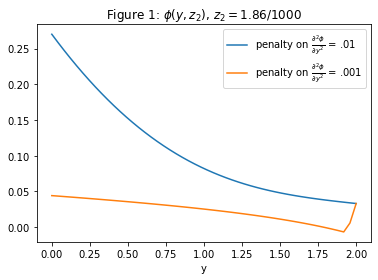

In [22]:
from utilities import compute_derivatives_2d

# temp = compute_derivatives_2d(ϕ_grid_5, 1, 1, 2./50)
# plt.plot(y_grid, ϕ_grid_1[25], label=r'penalty on $\frac{\partial^2 \phi}{\partial y^2}$ = .1')
plt.plot(y_grid, ϕ_grid_2[25], label=r'penalty on $\frac{\partial^2 \phi}{\partial y^2}$ = .01')
plt.plot(y_grid, ϕ_grid_3[25], label=r'penalty on $\frac{\partial^2 \phi}{\partial y^2}$ = .001')
# plt.plot(y_grid, ϕ_grid_4[25], label=r'penalty on $\frac{\partial^2 \phi}{\partial y^2}$ = 0')
plt.legend()
plt.title(r'Figure 1: $\phi(y, z_2)$, $z_2=1.86/1000$')
plt.xlabel('y')
plt.savefig('fig_1.pdf')

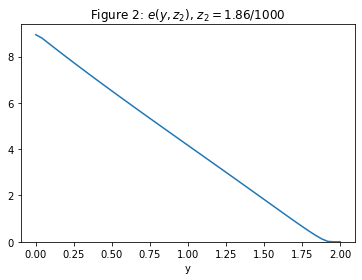

In [20]:
plt.plot(y_grid, e_grid_4[25], label='prob of high damage = 0.5')
# plt.plot(y_grid, e_grid_6[25], label='prob of high damage = 0.6')
# plt.plot(y_grid, e_grid_7[25], label='prob of high damage = 0.7')
plt.xlabel('y')
# plt.legend()
plt.title(r'Figure 2: $e(y, z_2)$, $z_2=1.86/1000$')
plt.ylim(0, None)
plt.savefig('fig_2.pdf')

In [ ]:
@njit
def simulation(y_grid, z_grid, e_grid, yoz_start=290, z_loc=25, T=100):
    Et = np.zeros(T+1)
    z = z_grid[z_loc]
    for i in range(T+1):
        Et[i] = np.interp(yoz_start*z, y_grid, e_grid[z_loc])
        yoz_start = yoz_start + Et[i]
        if yoz_start*z > 2:
            print('Warning')
    return Et


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

In [ ]:
T = 100
# Et = simulation(y_grid, z_grid, e_grid, yoz_start=290, z_loc=25, T=T)
Et_5 = simulation(y_grid, z_grid, e_grid_5, yoz_start=290, z_loc=25, T=T)
Et_6 = simulation(y_grid, z_grid, e_grid_6, yoz_start=290, z_loc=25, T=T)
Et_7 = simulation(y_grid, z_grid, e_grid_7, yoz_start=290, z_loc=25, T=T)

In [ ]:
plt.figure()
plt.title(r'Figure 2: Emission trajectory, $z_2=1.86/1000$')
plt.plot(Et_5, label='prob of high damage = 0.5')
plt.plot(Et_6, label='prob of high damage = 0.6')
plt.plot(Et_7, label='prob of high damage = 0.7')
plt.legend()
plt.ylim(0, 10)
plt.xlabel('Year')
plt.savefig('fig_2.pdf')

In [ ]:
(1+0.01/100)**(365*3)